# `Zomato Bangalore Restaurants: 02 - Data Cleaning & Preparation`

**Author:** Puneet Kumar Mishra
**Date:** 25-08-2025

## 1. Objective

This notebook documents the comprehensive data cleaning and preparation process for the Zomato Bangalore dataset. The primary goal is to transform the raw, messy data into a structured, reliable, and enriched format suitable for in-depth exploratory data analysis (EDA), feature engineering, and machine learning model training.

**The key stages of this process are:**
1.  **Initial Setup & Data Loading:** Configuring the environment and loading the raw data.
2.  **Schema & Data Type Correction:** Standardizing column names and fixing incorrect data types (e.g., `rate`, `cost_for_two`).
3.  **Text & Encoding Cleanup:** Systematically fixing widespread text encoding errors ("mojibake") across multiple columns.
4.  **Duplicate Removal:** Implementing a robust, multi-stage strategy to eliminate duplicate restaurant entries.
5.  **Missing Value Imputation:** Strategically filling missing data using context-aware methods.
6.  **Outlier & Skewness Treatment:** Analyzing the distribution of key numerical features and applying transformations to normalize them for modeling.

By the end of this notebook, we will have a "golden" dataset that will serve as the single source of truth for all subsequent analysis.

## 2. Initial Setup & Data Loading

This section handles the preliminary setup for our notebook. We import all necessary libraries and configure our environment for optimal performance and readability. This includes setting up `pandas` display options for clean outputs, a consistent theme for our `seaborn` visualizations, and a powerful `loguru` logger for detailed, colorized feedback on our operations.

In [1]:
# --- 1. CORE LIBRARIES ---
import os
import sys
import warnings

# --- 3. VISUALIZATION ---
import matplotlib.pyplot as plt
import numpy as np

# --- 2. DATA HANDLING & ANALYSIS ---
import pandas as pd
import seaborn as sns

# --- 8. UTILITIES ---
from loguru import logger
from tqdm.auto import tqdm

# ===================================================================
#                      CONFIGURATION
# ===================================================================

# --- 1. PANDAS SETTINGS ---
# Makes DataFrame outputs look professional
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 1000)
# Formats floats to 2 decimal places with comma separators (e.g., 1,234.56)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# --- 2. PLOTTING STYLE ---
# Sets a modern, clean style for all matplotlib and seaborn plots
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 100  # Makes plots sharper

# --- 3. LOGURU CONFIGURATION ---
# The "beautiful" and "advanced" logger you wanted
logger.remove()  # Remove the default handler
logger.add(
    sys.stdout,
    colorize=True,
    format=(
        "<green>{time:YYYY-MM-DD HH:mm:ss}</green> | "
        "<level>{level: <8}</level> | "
        "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - "
        "<level>{message}</level>"
    ),
)
logger.info("✅ All libraries imported and configurations set successfully!")

2025-08-26 18:24:50 | INFO     | __main__:<module>:49 - ✅ All libraries imported and configurations set successfully!


In [2]:
df = pd.read_csv("../data/raw/zomato_raw.csv")

### 2.1. Initial Data Inspection

We begin by loading the raw `zomato_raw.csv` file and performing an initial inspection using `df.info()`. This first look gives us a high-level overview of the dataset's structure, including the number of entries, column names, non-null counts, and data types.

**Initial Findings:**
- **Inconsistent Column Names:** Columns like `approx_cost(for two people)` and `listed_in(type)` are not in a clean format.
- **Incorrect Data Types:** Crucial columns like `rate`, `online_order`, `book_table`, and `approx_cost_for_two_people` are incorrectly loaded as `object` (string) type instead of numeric.
- **Missing Values:** There are significant missing values in key columns, most notably `dish_liked` and our target variable, `rate`.
- **Potential Encoding Issues:** The presence of complex text fields (`reviews_list`, `menu_item`) suggests potential for text encoding errors.

In [3]:
df.info(verbose=True, show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

## `Standarizing the column names`

## 3. Data Cleaning & Type Conversion

This phase focuses on fixing the foundational issues identified during our initial inspection. We will systematically clean and correct the data types of key columns to make them usable for analysis and modeling.

### 3.1. Standardizing Column Names

The first step is to create clean, consistent column names. We will convert all names to `snake_case` (e.g., `listed_in_city`) to make them easier to work with in code. This function automates the process for the entire DataFrame.

In [4]:
import re

import pandas as pd
from loguru import logger


def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes all column names in a DataFrame to a clean,
    snake_case format using a robust regular expression.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with cleaned column names.
    """
    df_cleaned = df.copy()

    logger.info("--- Standardizing column names ---")
    original_columns = df_cleaned.columns.tolist()
    logger.info(f"Original columns: {original_columns}")

    # 1. Use a list comprehension to build the new column names
    new_columns = []
    for col in original_columns:
        # a. Convert to lowercase
        clean_col = col.lower()
        # b. Use regex to replace any non-alphanumeric character with an underscore
        #    [^A-Za-z0-9_]+ means "one or more characters that are NOT letters, numbers, or underscore"
        clean_col = re.sub(r"[^A-Za-z0-9_]+", "_", clean_col)
        # c. Clean up any leading/trailing underscores that might result
        clean_col = clean_col.strip("_")
        new_columns.append(clean_col)

    # 2. Assign the new, cleaned names back to the DataFrame
    df_cleaned.columns = new_columns

    logger.success(f"Cleaned columns: {df_cleaned.columns.tolist()}")

    return df_cleaned


# --- HOW TO USE ---
# Assume 'df_with_messy_columns' is your current DataFrame
# df_cleaned_columns = standardize_column_names(df_with_messy_columns)

In [5]:
df = standardize_column_names(df)

2025-08-26 18:24:53 | INFO     | __main__:standardize_column_names:20 - --- Standardizing column names ---
2025-08-26 18:24:53 | INFO     | __main__:standardize_column_names:22 - Original columns: ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'approx_cost(for two people)', 'reviews_list', 'menu_item', 'listed_in(type)', 'listed_in(city)']
2025-08-26 18:24:53 | SUCCESS  | __main__:standardize_column_names:39 - Cleaned columns: ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'approx_cost_for_two_people', 'reviews_list', 'menu_item', 'listed_in_type', 'listed_in_city']


## `Fixing the mistakes in 'rate' column`

### 3.2. Cleaning the `rate` Column

The `rate` column is our target variable, but it's loaded as a string with inconsistencies like `"NEW"`, `"-"`, and a `/5` suffix. This function robustly handles these issues by:
1.  Replacing non-rating strings like "NEW" and "-" with `NaN`.
2.  Splitting the string (e.g., "4.1/5") to isolate the numerical rating.
3.  Converting the cleaned column to a `float64` data type, coercing any remaining errors to `NaN`.

In [6]:
from typing import List


def clean_rate_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the 'rate' column by parsing string ratings, converting them
    to a numeric format, and handling special values. This function is robust
    and uses explicit type hints.

    Args:
        df (pd.DataFrame): The input DataFrame. Must contain a 'rate' column.

    Returns:
        pd.DataFrame: A new DataFrame with the 'rate' column cleaned.
    """
    logger.info("--- Cleaning the 'rate' column ---")

    # 1. Input Validation: Check if the 'rate' column exists and is not None.
    if "rate" not in df.columns or df["rate"] is None:
        error_msg = "DataFrame must have a valid 'rate' column."
        logger.error(error_msg)
        raise ValueError(error_msg)

    df_cleaned: pd.DataFrame = df.copy()

    # 2. Define a list of all known non-numeric rating strings.
    bad_ratings: List[str] = ["NEW", "-"]

    # 3. Set all rows with these bad ratings to NaN.
    # We ensure the column is treated as a string before using .isin() to avoid errors.
    df_cleaned.loc[df_cleaned["rate"].astype(str).isin(bad_ratings), "rate"] = np.nan

    # 4. Use vectorized string operations to split the string and get the rating.
    # The .str accessor safely handles NaN values.
    df_cleaned["rate"] = df_cleaned["rate"].str.split("/").str[0]

    # 5. Convert the entire column to a numeric type.
    # 'coerce' will turn any other problematic values into NaN.
    df_cleaned["rate"] = pd.to_numeric(df_cleaned["rate"], errors="coerce")

    logger.success(f"Cleaned 'rate' column. Dtype is now: {df_cleaned['rate'].dtype}")

    return df_cleaned


# --- HOW TO USE ---
# 1. Make sure 'df' is freshly loaded from the CSV.
# df = pd.read_csv("../data/raw/zomato_raw.csv")

# 2. Call the function on the entire DataFrame.
# df_after_rate_cleaning = clean_rate_column(df)

# 3. Check the results.
# print(df_after_rate_cleaning['rate'].dtype)
# print(df_after_rate_cleaning['rate'].unique())

In [7]:
df = clean_rate_column(df)

2025-08-26 18:24:53 | INFO     | __main__:clean_rate_column:16 - --- Cleaning the 'rate' column ---
2025-08-26 18:24:53 | SUCCESS  | __main__:clean_rate_column:41 - Cleaned 'rate' column. Dtype is now: float64


In [8]:
df["rate"].isna().sum()

np.int64(10052)

## `Fixing the encoding mistakes, this happens when utf-8 encoded document is parsed as Latin-1 or something else`

### 3.3. Fixing Text Encoding Errors ("Mojibake")

A significant data quality issue is the presence of "mojibake" – garbled text resulting from incorrect character encoding (e.g., `CafÃƒÂ©` instead of `Café`). We will build a powerful, "god-level" function to audit and fix these issues across all relevant text columns.

This function, `clean_text_column`, operates in two modes:
- **`simple` mode:** For columns with plain text (`name`, `address`).
- **`structured` mode:** For columns containing string representations of Python lists (`reviews_list`, `menu_item`).

It uses the `ftfy` library for intelligent fixing and provides a comprehensive "Before & After" audit report, including visualizations, to verify the effectiveness of the cleaning process. The "surgical strike" functionality is an advanced feature designed to remove residual, hard-to-fix garbage characters.

In [9]:
import ast
import re
from typing import Any, List, Tuple

import ftfy
import ftfy.bad_codecs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from loguru import logger

# You must install pandarallel and tqdm first: pip install pandarallel tqdm
from pandarallel import pandarallel
from tqdm.auto import tqdm

# --- INITIALIZATION ---
pandarallel.initialize(progress_bar=True, nb_workers=14)


# --- HELPER FUNCTIONS (Defined at the top level for pandarallel) ---
def needs_fixing_simple(text: Any) -> bool:
    """Checks a simple string for encoding errors."""
    import ftfy

    if not isinstance(text, str):
        return False
    try:
        return ftfy.is_bad(text)
    except Exception:
        return False


def needs_fixing_structured(cell_data: Any) -> bool:
    """A robust check for encoding errors INSIDE a parsed list/tuple structure."""
    import ftfy

    if not isinstance(cell_data, list):
        return False
    for item in cell_data:
        text_to_check = ""
        if isinstance(item, tuple) and len(item) == 2:
            _, text_to_check = item
        elif isinstance(item, str):
            text_to_check = item
        if isinstance(text_to_check, str) and ftfy.is_bad(text_to_check):
            return True
    return False


def fix_simple(text: Any) -> Any:
    """Applies ftfy to a simple string."""
    import ftfy

    return ftfy.fix_text(text) if isinstance(text, str) else text


def fix_and_parse_structured(cell_str: Any) -> Any:
    """
    Robustly fixes and parses a string containing a Python literal.
    This version preserves the original logic.
    """
    import ast

    import ftfy

    if not isinstance(cell_str, str):
        return cell_str
    try:
        fixed_str = ftfy.fix_text(cell_str)
        parsed_obj = ast.literal_eval(fixed_str)
        if isinstance(parsed_obj, list):
            cleaned_items = []
            for item in parsed_obj:
                if isinstance(item, tuple) and len(item) == 2:
                    part1, part2 = item
                    cleaned_items.append((part1, ftfy.fix_text(str(part2))))
                elif isinstance(item, str):
                    cleaned_items.append(ftfy.fix_text(item))
            return cleaned_items
        return []
    except Exception:
        return []


def surgically_remove_garbage_from_structured(cell_data: Any) -> Tuple[Any, List[str]]:
    """
    Performs the final surgical strike on already-parsed list data.
    Returns the cleaned list AND a report of removed garbage.
    """
    # --- START: Logic stolen directly from ftfy.badness ---
    import re

    MOJIBAKE_CATEGORIES = {
        # Characters that appear in many different contexts. Sequences that contain
        # them are not inherently mojibake
        "common": (
            "\N{NO-BREAK SPACE}"
            "\N{SOFT HYPHEN}"
            "\N{MIDDLE DOT}"
            "\N{ACUTE ACCENT}"
            "\N{EN DASH}"
            "\N{EM DASH}"
            "\N{HORIZONTAL BAR}"
            "\N{HORIZONTAL ELLIPSIS}"
            "\N{RIGHT SINGLE QUOTATION MARK}"
        ),
        # the C1 control character range, which have no uses outside of mojibake anymore
        "c1": "\x80-\x9f",
        # Characters that are nearly 100% used in mojibake
        "bad": (
            "\N{BROKEN BAR}"
            "\N{CURRENCY SIGN}"
            "\N{DIAERESIS}"
            "\N{NOT SIGN}"
            "\N{MACRON}"
            "\N{CEDILLA}"
            "\N{LATIN SMALL LETTER F WITH HOOK}"
            "\N{MODIFIER LETTER CIRCUMFLEX ACCENT}"  # it's not a modifier
            "\N{CARON}"
            "\N{BREVE}"
            "\N{OGONEK}"
            "\N{SMALL TILDE}"
            "\N{DAGGER}"
            "\N{DOUBLE DAGGER}"
            "\N{PER MILLE SIGN}"
            "\N{REVERSED NOT SIGN}"
            "\N{LOZENGE}"
            "\ufffd"
            # Theoretically these would appear in 'numeric' contexts, but when they
            # co-occur with other mojibake characters, it's not really ambiguous
            "\N{FEMININE ORDINAL INDICATOR}"
            "\N{MASCULINE ORDINAL INDICATOR}"
        ),
        # Characters used in legalese
        "law": ("\N{PILCROW SIGN}\N{SECTION SIGN}"),
        "currency": (
            "\N{CENT SIGN}\N{POUND SIGN}\N{YEN SIGN}\N{PESETA SIGN}\N{EURO SIGN}"
        ),
        "start_punctuation": (
            "\N{INVERTED EXCLAMATION MARK}"
            "\N{LEFT-POINTING DOUBLE ANGLE QUOTATION MARK}"
            "\N{INVERTED QUESTION MARK}"
            "\N{COPYRIGHT SIGN}"
            "\N{GREEK TONOS}"
            "\N{GREEK DIALYTIKA TONOS}"
            "\N{LEFT SINGLE QUOTATION MARK}"
            "\N{SINGLE LOW-9 QUOTATION MARK}"
            "\N{LEFT DOUBLE QUOTATION MARK}"
            "\N{DOUBLE LOW-9 QUOTATION MARK}"
            "\N{BULLET}"
            "\N{SINGLE LEFT-POINTING ANGLE QUOTATION MARK}"
            "\uf8ff"  # OS-specific symbol, usually the Apple logo
        ),
        "end_punctuation": (
            "\N{REGISTERED SIGN}"
            "\N{RIGHT-POINTING DOUBLE ANGLE QUOTATION MARK}"
            "\N{DOUBLE ACUTE ACCENT}"
            "\N{RIGHT DOUBLE QUOTATION MARK}"
            "\N{SINGLE RIGHT-POINTING ANGLE QUOTATION MARK}"
            "\N{TRADE MARK SIGN}"
        ),
        "numeric": (
            "\N{SUPERSCRIPT TWO}"
            "\N{SUPERSCRIPT THREE}"
            "\N{SUPERSCRIPT ONE}"
            "\N{PLUS-MINUS SIGN}"
            "\N{VULGAR FRACTION ONE QUARTER}"
            "\N{VULGAR FRACTION ONE HALF}"
            "\N{VULGAR FRACTION THREE QUARTERS}"
            "\N{MULTIPLICATION SIGN}"
            "\N{MICRO SIGN}"
            "\N{DIVISION SIGN}"
            "\N{FRACTION SLASH}"
            "\N{PARTIAL DIFFERENTIAL}"
            "\N{INCREMENT}"
            "\N{N-ARY PRODUCT}"
            "\N{N-ARY SUMMATION}"
            "\N{SQUARE ROOT}"
            "\N{INFINITY}"
            "\N{INTERSECTION}"
            "\N{INTEGRAL}"
            "\N{ALMOST EQUAL TO}"
            "\N{NOT EQUAL TO}"
            "\N{IDENTICAL TO}"
            "\N{LESS-THAN OR EQUAL TO}"
            "\N{GREATER-THAN OR EQUAL TO}"
            "\N{NUMERO SIGN}"
        ),
        # Letters that might be used to make emoticon faces (kaomoji), and
        # therefore might need to appear in more improbable-looking contexts.
        #
        # These are concatenated character ranges for use in a regex. I know
        # they look like faces themselves. I think expressing the ranges like
        # this helps to illustrate why we need to be careful with these
        # characters.
        "kaomoji": (
            "Ò-Ö"
            "Ù-Ü"
            "ò-ö"
            "ø-ü"
            "\N{LATIN CAPITAL LETTER O WITH DOUBLE ACUTE}"
            "\N{LATIN CAPITAL LETTER O WITH MACRON}"
            "\N{LATIN CAPITAL LETTER U WITH MACRON}"
            "\N{LATIN CAPITAL LETTER U WITH OGONEK}"
            "\N{DEGREE SIGN}"
        ),
        "upper_accented": (
            # LATIN CAPITAL LETTER A WITH GRAVE - LATIN CAPITAL LETTER N WITH TILDE
            "\xc0-\xd1"
            # skip capital O's and U's that could be used in kaomoji, but
            # include Ø because it's very common in Arabic mojibake:
            "\N{LATIN CAPITAL LETTER O WITH STROKE}"
            "\N{LATIN CAPITAL LETTER U WITH DIAERESIS}"
            "\N{LATIN CAPITAL LETTER Y WITH ACUTE}"
            "\N{LATIN CAPITAL LETTER A WITH BREVE}"
            "\N{LATIN CAPITAL LETTER A WITH MACRON}"
            "\N{LATIN CAPITAL LETTER A WITH OGONEK}"
            "\N{LATIN CAPITAL LETTER C WITH ACUTE}"
            "\N{LATIN CAPITAL LETTER C WITH CARON}"
            "\N{LATIN CAPITAL LETTER D WITH CARON}"
            "\N{LATIN CAPITAL LETTER D WITH STROKE}"
            "\N{LATIN CAPITAL LETTER E WITH OGONEK}"
            "\N{LATIN CAPITAL LETTER E WITH CARON}"
            "\N{LATIN CAPITAL LETTER E WITH MACRON}"
            "\N{LATIN CAPITAL LETTER E WITH DOT ABOVE}"
            "\N{LATIN CAPITAL LETTER G WITH BREVE}"
            "\N{LATIN CAPITAL LETTER G WITH CEDILLA}"
            "\N{LATIN CAPITAL LETTER I WITH DOT ABOVE}"
            "\N{LATIN CAPITAL LETTER I WITH MACRON}"
            "\N{LATIN CAPITAL LETTER K WITH CEDILLA}"
            "\N{LATIN CAPITAL LETTER L WITH ACUTE}"
            "\N{LATIN CAPITAL LETTER L WITH CARON}"
            "\N{LATIN CAPITAL LETTER L WITH STROKE}"
            "\N{LATIN CAPITAL LETTER L WITH CEDILLA}"
            "\N{LATIN CAPITAL LETTER N WITH ACUTE}"
            "\N{LATIN CAPITAL LETTER N WITH CARON}"
            "\N{LATIN CAPITAL LETTER N WITH CEDILLA}"
            "\N{LATIN CAPITAL LIGATURE OE}"
            "\N{LATIN CAPITAL LETTER R WITH CARON}"
            "\N{LATIN CAPITAL LETTER S WITH ACUTE}"
            "\N{LATIN CAPITAL LETTER S WITH CEDILLA}"
            "\N{LATIN CAPITAL LETTER S WITH CARON}"
            "\N{LATIN CAPITAL LETTER T WITH CEDILLA}"
            "\N{LATIN CAPITAL LETTER T WITH CARON}"
            "\N{LATIN CAPITAL LETTER U WITH RING ABOVE}"
            "\N{LATIN CAPITAL LETTER U WITH DOUBLE ACUTE}"
            "\N{LATIN CAPITAL LETTER Y WITH DIAERESIS}"
            "\N{LATIN CAPITAL LETTER Z WITH ACUTE}"
            "\N{LATIN CAPITAL LETTER Z WITH DOT ABOVE}"
            "\N{LATIN CAPITAL LETTER Z WITH CARON}"
            "\N{CYRILLIC CAPITAL LETTER GHE WITH UPTURN}"
        ),
        "lower_accented": (
            "\N{LATIN SMALL LETTER SHARP S}"
            # LATIN SMALL LETTER A WITH GRAVE - LATIN SMALL LETTER N WITH TILDE
            "\xe0-\xf1"
            # skip o's and u's that could be used in kaomoji
            "\N{LATIN SMALL LETTER A WITH BREVE}"
            "\N{LATIN SMALL LETTER A WITH OGONEK}"
            "\N{LATIN SMALL LETTER A WITH MACRON}"
            "\N{LATIN SMALL LETTER C WITH ACUTE}"
            "\N{LATIN SMALL LETTER C WITH CARON}"
            "\N{LATIN SMALL LETTER D WITH CARON}"
            "\N{LATIN SMALL LETTER D WITH STROKE}"
            "\N{LATIN SMALL LETTER E WITH OGONEK}"
            "\N{LATIN SMALL LETTER E WITH CARON}"
            "\N{LATIN SMALL LETTER E WITH MACRON}"
            "\N{LATIN SMALL LETTER E WITH DOT ABOVE}"
            "\N{LATIN SMALL LETTER G WITH BREVE}"
            "\N{LATIN SMALL LETTER G WITH CEDILLA}"
            "\N{LATIN SMALL LETTER I WITH OGONEK}"
            "\N{LATIN SMALL LETTER I WITH MACRON}"
            "\N{LATIN SMALL LETTER K WITH CEDILLA}"
            "\N{LATIN SMALL LETTER L WITH ACUTE}"
            "\N{LATIN SMALL LETTER L WITH CARON}"
            "\N{LATIN SMALL LETTER L WITH STROKE}"
            "\N{LATIN SMALL LETTER L WITH CEDILLA}"
            "\N{LATIN SMALL LIGATURE OE}"
            "\N{LATIN SMALL LETTER R WITH ACUTE}"
            "\N{LATIN SMALL LETTER S WITH ACUTE}"
            "\N{LATIN SMALL LETTER S WITH CEDILLA}"
            "\N{LATIN SMALL LETTER S WITH CARON}"
            "\N{LATIN SMALL LETTER T WITH CARON}"
            "\N{LATIN SMALL LETTER U WITH DIAERESIS}"
            "\N{LATIN SMALL LETTER Z WITH ACUTE}"
            "\N{LATIN SMALL LETTER Z WITH DOT ABOVE}"
            "\N{LATIN SMALL LETTER Z WITH CARON}"
            "\N{CYRILLIC SMALL LETTER GHE WITH UPTURN}"
            "\N{LATIN SMALL LIGATURE FI}"
            "\N{LATIN SMALL LIGATURE FL}"
        ),
        "upper_common": (
            "\N{LATIN CAPITAL LETTER THORN}"
            "\N{GREEK CAPITAL LETTER ALPHA}-\N{GREEK CAPITAL LETTER OMEGA}"
            # not included under 'accented' because these can commonly
            # occur at ends of words, in positions where they'd be detected
            # as mojibake
            "\N{GREEK CAPITAL LETTER ALPHA WITH TONOS}"
            "\N{GREEK CAPITAL LETTER EPSILON WITH TONOS}"
            "\N{GREEK CAPITAL LETTER ETA WITH TONOS}"
            "\N{GREEK CAPITAL LETTER IOTA WITH TONOS}"
            "\N{GREEK CAPITAL LETTER OMICRON WITH TONOS}"
            "\N{GREEK CAPITAL LETTER UPSILON WITH TONOS}"
            "\N{GREEK CAPITAL LETTER OMEGA WITH TONOS}"
            "\N{GREEK CAPITAL LETTER IOTA WITH DIALYTIKA}"
            "\N{GREEK CAPITAL LETTER UPSILON WITH DIALYTIKA}"
            "\N{CYRILLIC CAPITAL LETTER IO}-\N{CYRILLIC CAPITAL LETTER YA}"
        ),
        "lower_common": (
            # lowercase thorn does not appear in mojibake
            "\N{GREEK SMALL LETTER ALPHA}-\N{GREEK SMALL LETTER OMEGA}"
            "\N{GREEK SMALL LETTER ALPHA WITH TONOS}"
            "\N{GREEK SMALL LETTER EPSILON WITH TONOS}"
            "\N{GREEK SMALL LETTER ETA WITH TONOS}"
            "\N{GREEK SMALL LETTER IOTA WITH TONOS}"
            "\N{GREEK SMALL LETTER UPSILON WITH DIALYTIKA AND TONOS}"
            "\N{CYRILLIC SMALL LETTER A}-\N{CYRILLIC SMALL LETTER DZHE}"
        ),
        "box": (
            # omit the single horizontal line, might be used in kaomoji
            "│┌┐┘├┤┬┼"
            "\N{BOX DRAWINGS DOUBLE HORIZONTAL}-\N{BOX DRAWINGS DOUBLE VERTICAL AND HORIZONTAL}"
            "▀▄█▌▐░▒▓"
        ),
    }

    # We can now build a regular expression that detects unlikely juxtapositions
    # of characters, mostly based on their categories.
    #
    # Another regular expression, which detects sequences that look more specifically
    # like UTF-8 mojibake, appears in chardata.py.
    #
    # This is a verbose regular expression, with whitespace added for somewhat more
    # readability. Remember that the only spaces that count as literal spaces in this
    # expression are ones inside character classes (square brackets).

    garbage_pattern = re.compile(
        r"""
        [{c1}]
        |
        [{bad}{lower_accented}{upper_accented}{box}{start_punctuation}{end_punctuation}{currency}{numeric}{law}] [{bad}]
        |
        [a-zA-Z] [{lower_common}{upper_common}] [{bad}]
        |
        [{bad}] [{lower_accented}{upper_accented}{box}{start_punctuation}{end_punctuation}{currency}{numeric}{law}]
        |
        [{lower_accented}{lower_common}{box}{end_punctuation}{currency}{numeric}] [{upper_accented}]
        |
        [{box}{end_punctuation}{currency}{numeric}] [{lower_accented}]
        |
        [{lower_accented}{box}{end_punctuation}] [{currency}]
        |
        \s [{upper_accented}] [{currency}]
        |
        [{upper_accented}{box}] [{numeric}{law}]
        |
        [{lower_accented}{upper_accented}{box}{currency}{end_punctuation}] [{start_punctuation}] [{numeric}]
        |
        [{lower_accented}{upper_accented}{currency}{numeric}{box}{law}] [{end_punctuation}] [{start_punctuation}]
        |
        [{currency}{numeric}{box}] [{start_punctuation}]
        |
        [a-z] [{upper_accented}] [{start_punctuation}{currency}]
        |
        [{box}] [{kaomoji}]
        |
        [{lower_accented}{upper_accented}{currency}{numeric}{start_punctuation}{end_punctuation}{law}] [{box}]
        |
        [{box}] [{end_punctuation}]
        |
        [{lower_accented}{upper_accented}] [{start_punctuation}{end_punctuation}] \w
        |
    
        # The ligature œ when not followed by an unaccented Latin letter
        [Œœ][^A-Za-z]
        |
    
        # Degree signs after capital letters
        [{upper_accented}]°
        |
    
        # Common Windows-1252 2-character mojibake that isn't covered by the cases above
        [ÂÃÎÐ][€œŠš¢£Ÿž\xa0\xad®©°·»{start_punctuation}{end_punctuation}–—´]
        |
        × [²³]
        |
        # Windows-1252 mojibake of Arabic words needs to include the 'common' characters.
        # To compensate, we require four characters to be matched.
          [ØÙ] [{common}{currency}{bad}{numeric}{start_punctuation}ŸŠ®°µ»]
          [ØÙ] [{common}{currency}{bad}{numeric}{start_punctuation}ŸŠ®°µ»]
        |
    
        # Windows-1252 mojibake that starts 3-character sequences for some South Asian
        # alphabets
        à[²µ¹¼½¾]
        |
    
        # MacRoman mojibake that isn't covered by the cases above
        √[±∂†≠®™´≤≥¥µø]
        |
        ≈[°¢]
        |
        ‚Ä[ìîïòôúùû†°¢π]
        |
        ‚[âó][àä°ê]
        |
    
        # Windows-1251 mojibake of characters in the U+2000 range
        вЂ
        |
    
        # Windows-1251 mojibake of Latin-1 characters and/or the Cyrillic alphabet.
        # Because the 2-character sequences involved here may be common, we require
        # seeing a 3-character sequence.
        [ВГРС][{c1}{bad}{start_punctuation}{end_punctuation}{currency}°µ][ВГРС]
        |
        # A distinctive five-character sequence of Cyrillic letters, which can be
        # Windows-1251 mojibake on top of Latin-1 mojibake of Windows-1252 characters.
        # Require a Latin letter nearby.
        ГўВЂВ.[A-Za-z ]
        |
    
        # Windows-1252 encodings of 'à' and 'á', as well as \xa0 itself
        Ã[\xa0¡]
        |
        [a-z]\s?[ÃÂ][ ]
        |
        ^[ÃÂ][ ]
        |
    
        # Cases where Â precedes a character as an encoding of exactly the same
        # character, and the character is common enough
        [a-z.,?!{end_punctuation}] Â [ {start_punctuation}{end_punctuation}]
        |
    
        # Windows-1253 mojibake of characters in the U+2000 range
        β€[™\xa0Ά\xad®°]
        |
    
        # Windows-1253 mojibake of Latin-1 characters and/or the Greek alphabet
        [ΒΓΞΟ][{c1}{bad}{start_punctuation}{end_punctuation}{currency}°][ΒΓΞΟ]
        |
    
        # Windows-1257 mojibake of characters in the U+2000 range
        ā€
        """.format(
            **MOJIBAKE_CATEGORIES
        ),
        re.VERBOSE,
    )

    all_removed = []

    if not isinstance(cell_data, list):
        return cell_data, all_removed

    final_list = []
    for item in cell_data:
        if isinstance(item, tuple) and len(item) == 2:
            part1, part2 = item
            text_to_clean = str(part2)
            removed_parts = garbage_pattern.findall(text_to_clean)
            clean_part2 = garbage_pattern.sub("", text_to_clean)
            final_list.append((part1, clean_part2))
            all_removed.extend(removed_parts)
        elif isinstance(item, str):
            removed_parts = garbage_pattern.findall(item)
            clean_item = garbage_pattern.sub("", item)
            final_list.append(clean_item)
            all_removed.extend(removed_parts)
    return final_list, all_removed


# --- MAIN FUNCTIONS ---
def generate_audit_report(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    column_name: str,
    corrupted_mask_before: pd.Series,
    mode: str,
):
    """Generates a detailed and HONEST audit report for a cleaning operation."""
    corrupted_count_before = corrupted_mask_before.sum()
    total_rows = len(df_before)

    if corrupted_count_before == 0:
        logger.success(f"No issues found in '{column_name}'. Column is clean.")
        return

    percentage_before = (corrupted_count_before / total_rows) * 100
    logger.warning(
        f"Found {corrupted_count_before:,} rows ({percentage_before:.2f}%) with issues in '{column_name}'."
    )

    corrupted_indices = df_before[corrupted_mask_before].index
    sample_indices = np.random.choice(
        corrupted_indices, size=min(3, corrupted_count_before), replace=False
    )

    html_before = (
        "<div style='background-color: #FFF3CD; border-left: 5px solid #FFC107; padding: 10px; margin-bottom: 10px;'><h3 style='margin-top: 0; color: #856404;'>🔎 Before Fixing:</h3></div>"
        + df_before.loc[sample_indices][[column_name]]
        .style.set_properties(**{"white-space": "pre-wrap", "text-align": "left"})
        .to_html()
    )
    display(HTML(html_before))

    html_after = (
        "<div style='background-color: #D4EDDA; border-left: 5px solid #28A745; padding: 10px; margin-bottom: 10px;'><h3 style='margin-top: 0; color: #155724;'>✅ After Fixing:</h3></div>"
        + df_after.loc[sample_indices][[column_name]]
        .style.set_properties(**{"white-space": "pre-wrap", "text-align": "left"})
        .to_html()
    )
    display(HTML(html_after))

    logger.info("Re-running audit on cleaned data for verification...")
    if mode == "simple":
        corrupted_mask_after = df_after[column_name].parallel_apply(needs_fixing_simple)
    else:  # structured
        corrupted_mask_after = df_after[column_name].parallel_apply(
            needs_fixing_structured
        )

    corrupted_count_after = corrupted_mask_after.sum()
    if corrupted_count_after == 0:
        logger.success("Verification complete: All detected issues have been fixed.")
    else:
        logger.error(
            f"Verification FAILED: <red>{corrupted_count_after:,} issues remain</red> after cleaning."
        )

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'Data Quality Audit: "{column_name}"', fontsize=16)

    sns.barplot(
        ax=axes[0],
        x=["Clean", "Corrupted"],
        y=[total_rows - corrupted_count_before, corrupted_count_before],
        hue=["Clean", "Corrupted"],
        palette=["#66c2a5", "#fc8d62"],
        legend=False,
    )
    axes[0].set_title("Before Cleaning")
    axes[0].set_ylabel("Number of Rows")

    sns.barplot(
        ax=axes[1],
        x=["Clean", "Corrupted"],
        y=[total_rows - corrupted_count_after, corrupted_count_after],
        hue=["Clean", "Corrupted"],
        palette=["#66c2a5", "#fc8d62"],
        legend=False,
    )
    axes[1].set_title("After Cleaning")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def clean_text_column(
    df: pd.DataFrame,
    column_name: str,
    mode: str = "simple",
    disable_progress_bar: bool = False,
) -> pd.DataFrame:
    """A unified, high-performance function to audit and clean text-based columns."""
    logger.info(f"--- Cleaning column '{column_name}' (mode: {mode}) ---")
    df_cleaned = df.copy()

    if disable_progress_bar:
        pandarallel.initialize(progress_bar=False, nb_workers=14)

    corrupted_mask = df_cleaned[column_name].parallel_apply(needs_fixing_simple)

    if corrupted_mask.sum() > 0:
        if mode == "simple":
            fixer_function = fix_simple
        elif mode == "structured":
            fixer_function = fix_and_parse_structured
        else:
            raise ValueError(
                f"Invalid mode: '{mode}'. Choose 'simple' or 'structured'."
            )

        logger.info("Starting the fixing...")
        df_cleaned.loc[corrupted_mask, column_name] = df_cleaned.loc[
            corrupted_mask, column_name
        ].parallel_apply(fixer_function)

        # --- AUTOMATIC SURGICAL STRIKE FOR STRUCTURED COLUMNS ---
        if mode == "structured":
            logger.info(
                f"Performing surgical strike on '{column_name}' to remove final garbage..."
            )
            results = df_cleaned[column_name].parallel_apply(
                surgically_remove_garbage_from_structured
            )

            df_cleaned[column_name] = results.map(lambda x: x[0])
            removed_report = results.map(lambda x: x[1])

            # --- FULL REMOVAL REPORT (Your Request) ---
            full_removed_set = set(
                item for sublist in removed_report.tolist() for item in sublist if item
            )

            if full_removed_set:
                logger.warning(
                    f"Surgically removed {len(full_removed_set)} unique types of garbage."
                )
                logger.info("Full set of removed garbage:")
                print(sorted(list(full_removed_set)))
            else:
                logger.success("Surgical strike found no remaining garbage to remove.")

        generate_audit_report(df, df_cleaned, column_name, corrupted_mask, mode)
    else:
        logger.success(f"No encoding errors found in '{column_name}'. Column is clean.")

    if disable_progress_bar:
        pandarallel.initialize(progress_bar=True, nb_workers=8)

    return df_cleaned

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [10]:
df = clean_text_column(df, "url")

2025-08-26 18:24:53 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'url' (mode: simple) ---


2025-08-26 18:24:54 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'url'. Column is clean.


2025-08-26 18:24:54 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'address' (mode: simple) ---


2025-08-26 18:24:55 | INFO     | __main__:clean_text_column:587 - Starting the fixing...


2025-08-26 18:24:55 | WARNING  | __main__:generate_audit_report:493 - Found 20 rows (0.04%) with issues in 'address'.


,address
11802,"Ground Floor, Swami Vivekanand Road, Lido Multiplex No ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ¼, MG Road, Bangalore"
5455,"Ground Floor, Swami Vivekanand Road, Lido Multiplex No ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ¼, MG Road, Bangalore"
51174,"94 / 95, 4th Cross, ECC Road, Prithvi Layout, Near Ivory Studio One & DeenÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂs Academy, Whitefield, Bangalore, Bengaluru"


,address
11802,"Ground Floor, Swami Vivekanand Road, Lido Multiplex No ¼, MG Road, Bangalore"
5455,"Ground Floor, Swami Vivekanand Road, Lido Multiplex No ¼, MG Road, Bangalore"
51174,"94 / 95, 4th Cross, ECC Road, Prithvi Layout, Near Ivory Studio One & Deen's Academy, Whitefield, Bangalore, Bengaluru"


2025-08-26 18:24:55 | INFO     | __main__:generate_audit_report:518 - Re-running audit on cleaned data for verification...


2025-08-26 18:24:55 | SUCCESS  | __main__:generate_audit_report:528 - Verification complete: All detected issues have been fixed.


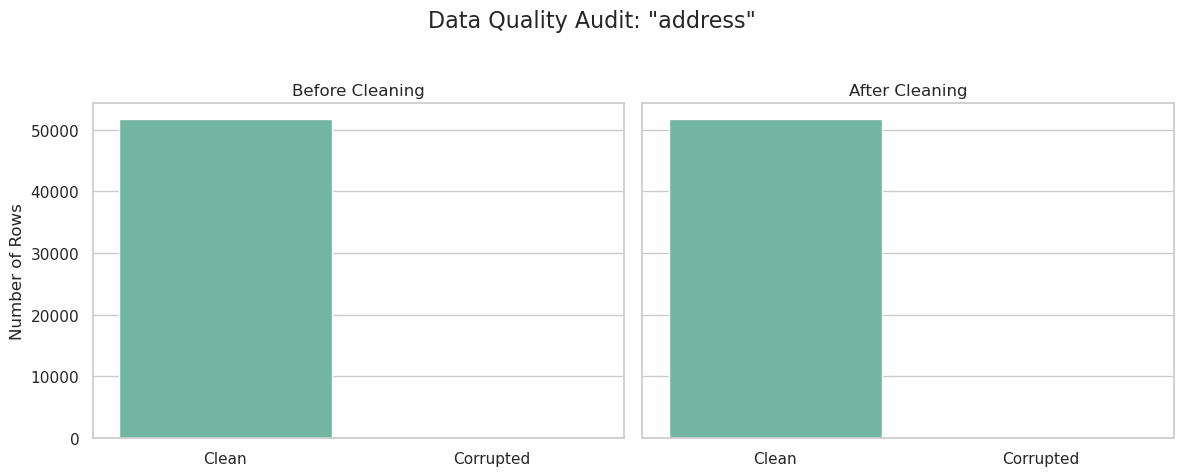

In [11]:
df = clean_text_column(df, "address")

2025-08-26 18:24:55 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'name' (mode: simple) ---


2025-08-26 18:24:56 | INFO     | __main__:clean_text_column:587 - Starting the fixing...


2025-08-26 18:24:56 | WARNING  | __main__:generate_audit_report:493 - Found 269 rows (0.52%) with issues in 'name'.


,name
41217,Chikki's CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ©
11636,Urban Solace - CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© for the Soul
47309,The CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© @ Saanchi


,name
41217,Chikki's Café
11636,Urban Solace - Café for the Soul
47309,The Café @ Saanchi


2025-08-26 18:24:56 | INFO     | __main__:generate_audit_report:518 - Re-running audit on cleaned data for verification...


2025-08-26 18:24:56 | SUCCESS  | __main__:generate_audit_report:528 - Verification complete: All detected issues have been fixed.


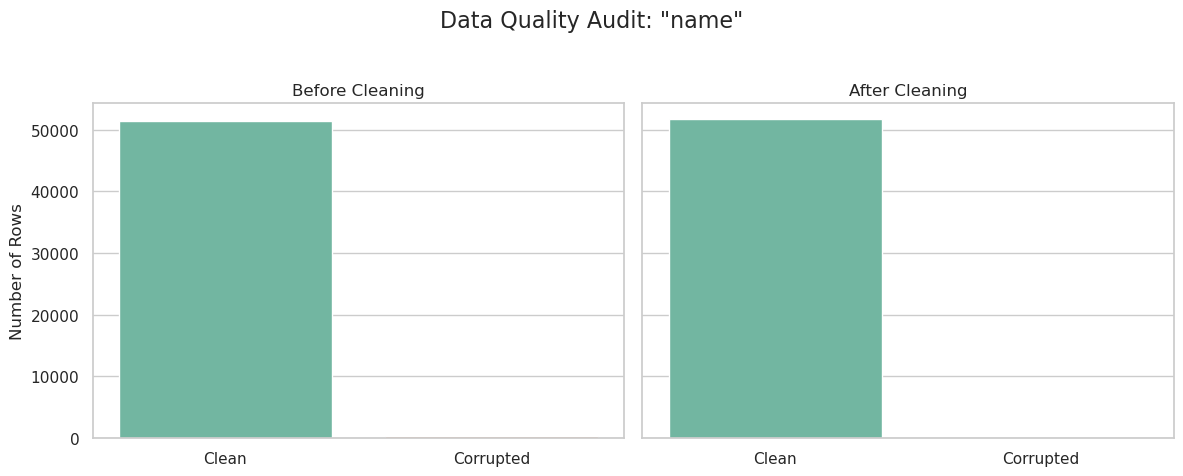

In [12]:
df = clean_text_column(df, "name")

In [13]:
df = clean_text_column(df, "location")

2025-08-26 18:24:56 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'location' (mode: simple) ---


2025-08-26 18:24:57 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'location'. Column is clean.


In [14]:
df = clean_text_column(df, "rest_type")

2025-08-26 18:24:57 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'rest_type' (mode: simple) ---


2025-08-26 18:24:57 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'rest_type'. Column is clean.


In [15]:
df = clean_text_column(df, "dish_liked")

2025-08-26 18:24:57 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'dish_liked' (mode: simple) ---


2025-08-26 18:24:57 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'dish_liked'. Column is clean.


In [16]:
df = clean_text_column(df, "cuisines")

2025-08-26 18:24:57 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'cuisines' (mode: simple) ---


2025-08-26 18:24:58 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'cuisines'. Column is clean.


2025-08-26 18:24:58 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'reviews_list' (mode: structured) ---


2025-08-26 18:25:04 | INFO     | __main__:clean_text_column:587 - Starting the fixing...


2025-08-26 18:26:40 | INFO     | __main__:clean_text_column:594 - Performing surgical strike on 'reviews_list' to remove final garbage...


2025-08-26 18:27:06 | WARNING  | __main__:clean_text_column:610 - Surgically removed 300 unique types of garbage.
2025-08-26 18:27:06 | INFO     | __main__:clean_text_column:613 - Full set of removed garbage:
['\x81', '\x8d', '\x8f', '\x90', '\x9d', '\xa0Â¥', '\xa0Ã£', '¢Ã', '£Â', '£Ã', '£ã', '¤¢', '¤Â', '¤Ã', '¤ã', '¤ï', '¥Â', '¥Ã', '¥ã', '¥ä', '¥å', '¥æ', '¦Â', '¦Ã', '¦ã', '¨Ã', '¨ã', '¨å', '¨é', 'ªÃ', 'ªã', '¬Ã', '®¢', '®Â', '®Ã', '®ã', '®ä', '®æ', '®é', '¯Ã', '¯ã', '¯ç', '¯è', '±Â', '±Ã', '²Â', '²Ã', '³Â', '³Ã', '³ã', 'µÂ', 'µÃ', 'µã', 'µæ', '¸Â', '¸Ã', '¹Â', '¹Ã', '¹ã', 'ºÂ', 'ºÃ', '»Ã', '»ã', '¼Â', '¼Ã', '¼ã', '¼å', '¼æ', '½Â', '½Ã', '¾Â', '¾Ã', '¾ã', '¾å', 'Â\xa0', 'Â¡Ã', 'Â¢', 'Â£', 'Â¤', 'Â¦', 'Â§', 'Â¨', 'Â©Ã', 'Âª', 'Â«B', 'Â«Ã', 'Â¬', 'Â\xad', 'Â®B', 'Â®Ã', 'Â¯', 'Â°', 'Â±', 'Â²', 'Â³', 'Â´', 'Âµ', 'Â¶', 'Â·', 'Â¸', 'Â¹', 'Âº', 'Â»', 'Â»Ã', 'Â¼', 'Â½', 'Â¾', 'Â¿', 'Â¿Ã', 'Âœ', 'ÂŠ', 'Âš', 'ÂŸ', 'Âž', 'Âƒ', 'Âˆ', 'Â˜', 'Â–', 'Â—', 'Â†', 'Â‡', 'Â•', 'Â•à', 'Â•ã', 'Â•ढ', 'Â•が'

2025-08-26 18:27:06 | INFO     | __main__:generate_audit_report:518 - Re-running audit on cleaned data for verification...


2025-08-26 18:27:16 | ERROR    | __main__:generate_audit_report:530 - Verification FAILED: <red>229 issues remain</red> after cleaning.


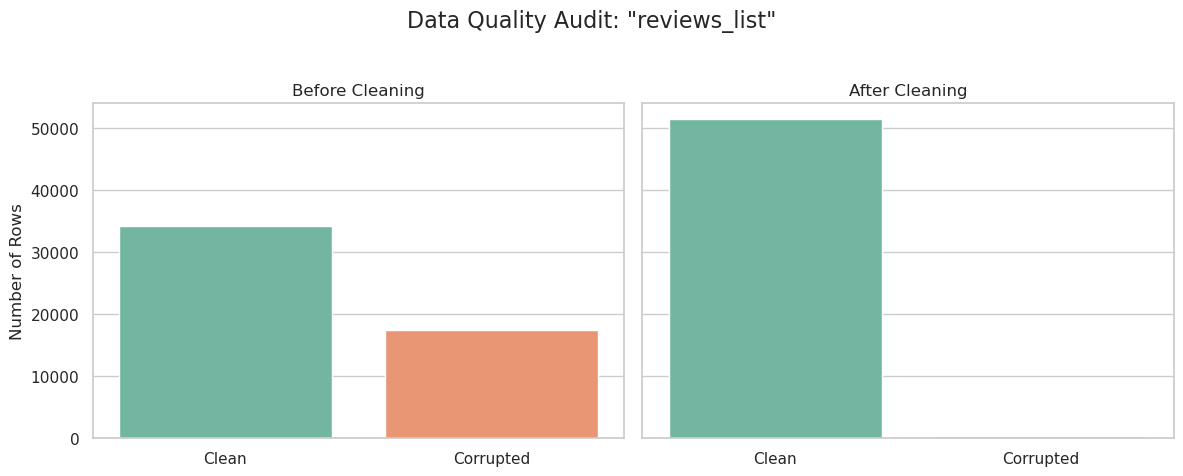

In [17]:
df = clean_text_column(df, "reviews_list", mode="structured")

2025-08-26 18:27:17 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'menu_item' (mode: structured) ---


2025-08-26 18:27:18 | INFO     | __main__:clean_text_column:587 - Starting the fixing...


2025-08-26 18:27:19 | INFO     | __main__:clean_text_column:594 - Performing surgical strike on 'menu_item' to remove final garbage...


2025-08-26 18:27:20 | SUCCESS  | __main__:clean_text_column:616 - Surgical strike found no remaining garbage to remove.
2025-08-26 18:27:20 | WARNING  | __main__:generate_audit_report:493 - Found 303 rows (0.59%) with issues in 'menu_item'.


2025-08-26 18:27:20 | INFO     | __main__:generate_audit_report:518 - Re-running audit on cleaned data for verification...


2025-08-26 18:27:21 | SUCCESS  | __main__:generate_audit_report:528 - Verification complete: All detected issues have been fixed.


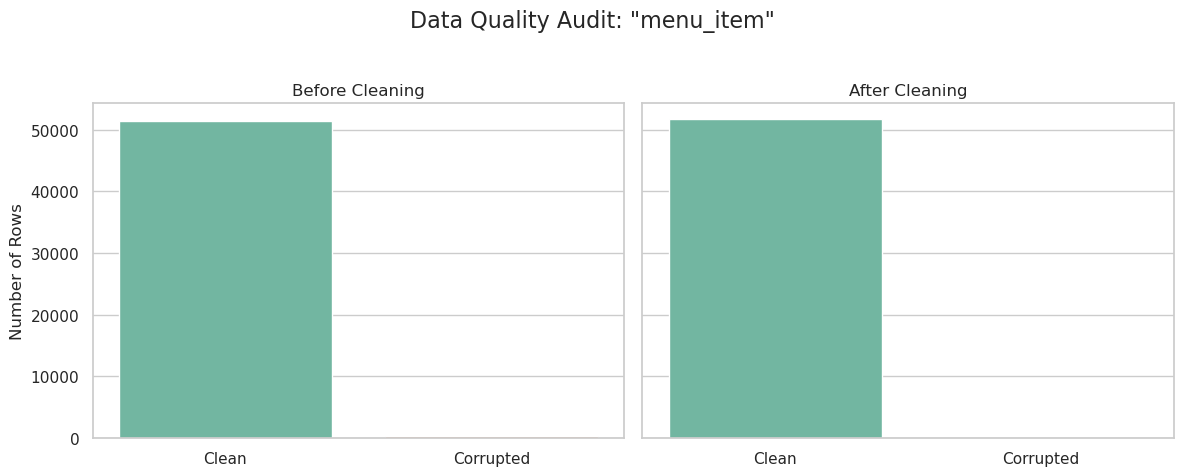

In [18]:
df = clean_text_column(df, "menu_item", mode="structured")

In [19]:
df = clean_text_column(df, "listed_in_type")

2025-08-26 18:27:22 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'listed_in_type' (mode: simple) ---


2025-08-26 18:27:22 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'listed_in_type'. Column is clean.


In [20]:
df = clean_text_column(df, "listed_in_city")

2025-08-26 18:27:22 | INFO     | __main__:clean_text_column:569 - --- Cleaning column 'listed_in_city' (mode: simple) ---


2025-08-26 18:27:23 | SUCCESS  | __main__:clean_text_column:620 - No encoding errors found in 'listed_in_city'. Column is clean.


## `Fixing approx_cost_for_two_people column`

### 3.4. Cleaning `cost_for_two` and Binary Columns

To complete the type conversion, we address the remaining columns.
- **`approx_cost_for_two_people`:** This column contains currency formatting (commas). We'll remove these and convert it to a `float64` type, renaming it to `cost_for_two` for convenience.
- **`online_order` & `book_table`:** These columns contain "Yes"/"No" strings. We will map them to a binary `int64` format (1 for Yes, 0 for No), which is ideal for machine learning models.

In [21]:
def clean_cost_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the 'approx_cost_for_two_people' column by removing commas
    and converting it to a numeric (float) type.
    """
    logger.info("--- Cleaning the 'approx_cost_for_two_people' column ---")

    df_cleaned = df.copy()

    # Rename the column for easier access
    df_cleaned = df_cleaned.rename(
        columns={"approx_cost_for_two_people": "cost_for_two"}
    )

    # Chain the cleaning operations for conciseness and efficiency
    df_cleaned["cost_for_two"] = pd.to_numeric(
        df_cleaned["cost_for_two"].str.replace(",", ""), errors="coerce"
    )

    logger.success(
        f"Cleaned and renamed column to 'cost_for_two'. "
        f"Dtype is now: {df_cleaned['cost_for_two'].dtype}"
    )

    return df_cleaned

In [22]:
df = clean_cost_column(df)

2025-08-26 18:27:23 | INFO     | __main__:clean_cost_column:6 - --- Cleaning the 'approx_cost_for_two_people' column ---
2025-08-26 18:27:23 | SUCCESS  | __main__:clean_cost_column:20 - Cleaned and renamed column to 'cost_for_two'. Dtype is now: float64


In [23]:
def clean_binary_columns(df: pd.DataFrame, columns_to_clean: List[str]) -> pd.DataFrame:
    """
    Converts specified columns containing 'Yes'/'No' strings into
    binary integers (1/0).
    """
    df_cleaned = df.copy()

    mapping_dict = {"Yes": 1, "No": 0}

    # Loop through each column you want to clean
    for col in columns_to_clean:
        # Apply the .map() method to each column (Series) individually
        df_cleaned[col] = df_cleaned[col].map(mapping_dict)
        logger.info(f"Column '{col}' converted to binary.")

    logger.success(f"Successfully converted {columns_to_clean} to binary format.")
    return df_cleaned


# --- HOW TO USE ---
# binary_cols = ['online_order', 'book_table']
# df_cleaned = clean_binary_columns(df_cleaned, binary_cols)

In [24]:
binary_cols = ["online_order", "book_table"]
df = clean_binary_columns(df, binary_cols)

2025-08-26 18:27:23 | INFO     | __main__:clean_binary_columns:14 - Column 'online_order' converted to binary.
2025-08-26 18:27:23 | INFO     | __main__:clean_binary_columns:14 - Column 'book_table' converted to binary.
2025-08-26 18:27:23 | SUCCESS  | __main__:clean_binary_columns:16 - Successfully converted ['online_order', 'book_table'] to binary format.


### 3.5. Analyzing Location Column Redundancy

The dataset contains two location-related columns: `location` (specific area) and `listed_in_city` (broader neighborhood). This analysis function investigates the relationship between them to determine if one is redundant. The heatmap visualization reveals that while they are related, `location` is much more granular (93 unique values) than `listed_in_city` (30 unique values).

**Decision:** Both columns contain valuable, distinct information. We will keep both for now and use them for feature engineering later.

In [25]:
def analyze_location_redundancy(df: pd.DataFrame):
    """
    Analyzes the similarity between the 'location' and 'listed_in_city' columns
    to determine if one is redundant.

    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    logger.info("--- Analyzing redundancy between 'location' and 'listed_in_city' ---")

    # 1. First, let's see the unique values in each column to get a feel for them.
    #    Print the number of unique values for both 'location' and 'listed_in_city'.
    logger.info(f"The no. of unique values in the columns are:")
    logger.info(f"1. location : {df['location'].nunique()}")
    logger.info(f"1. listed_in_city : {df['listed_in_city'].nunique()}")

    # 2. The core of the analysis: Calculate the percentage of rows where the
    #    value in 'location' is EXACTLY the same as the value in 'listed_in_city'.
    #    a. Create a boolean Series that is True where the columns match.
    #    b. Calculate the percentage of True values.
    matched_rows = matched_rows = (df["location"] == df["listed_in_city"]).sum()
    total_rows = len(df)
    percentage_same = (matched_rows / total_rows) * 100
    # 3. Log the result in a clear, informative message.
    #    For example: "XX.XX% of rows have the same value for 'location' and 'listed_in_city'."
    logger.info(
        f"The percentage of matching rows is : {percentage_same:.2f}%, and the no. of rows matched out of total rows is {matched_rows} / {total_rows}"
    )
    # 4. Based on the percentage, make a recommendation. If it's very high (e.g., > 95%),
    #    we can probably drop the 'location' column since it also has missing values.
    #    Log your recommendation.
    if percentage_same >= 95.0:
        logger.success("You can remove the location column")
    else:
        logger.warning("The percentage is less then the threshold")
    # 5. (Optional but good) Show a pd.crosstab() between the two columns to see the
    #    full relationship between them.
    crosstab = pd.crosstab(index=df["location"], columns=df["listed_in_city"])
    sns.heatmap(crosstab, cmap="coolwarm")

2025-08-26 18:27:23 | INFO     | __main__:analyze_location_redundancy:9 - --- Analyzing redundancy between 'location' and 'listed_in_city' ---
2025-08-26 18:27:23 | INFO     | __main__:analyze_location_redundancy:13 - The no. of unique values in the columns are:
2025-08-26 18:27:23 | INFO     | __main__:analyze_location_redundancy:14 - 1. location : 93
2025-08-26 18:27:23 | INFO     | __main__:analyze_location_redundancy:15 - 1. listed_in_city : 30
2025-08-26 18:27:23 | INFO     | __main__:analyze_location_redundancy:26 - The percentage of matching rows is : 30.98%, and the no. of rows matched out of total rows is 16020 / 51717
2025-08-26 18:27:23 | WARNING  | __main__:analyze_location_redundancy:35 - The percentage is less then the threshold


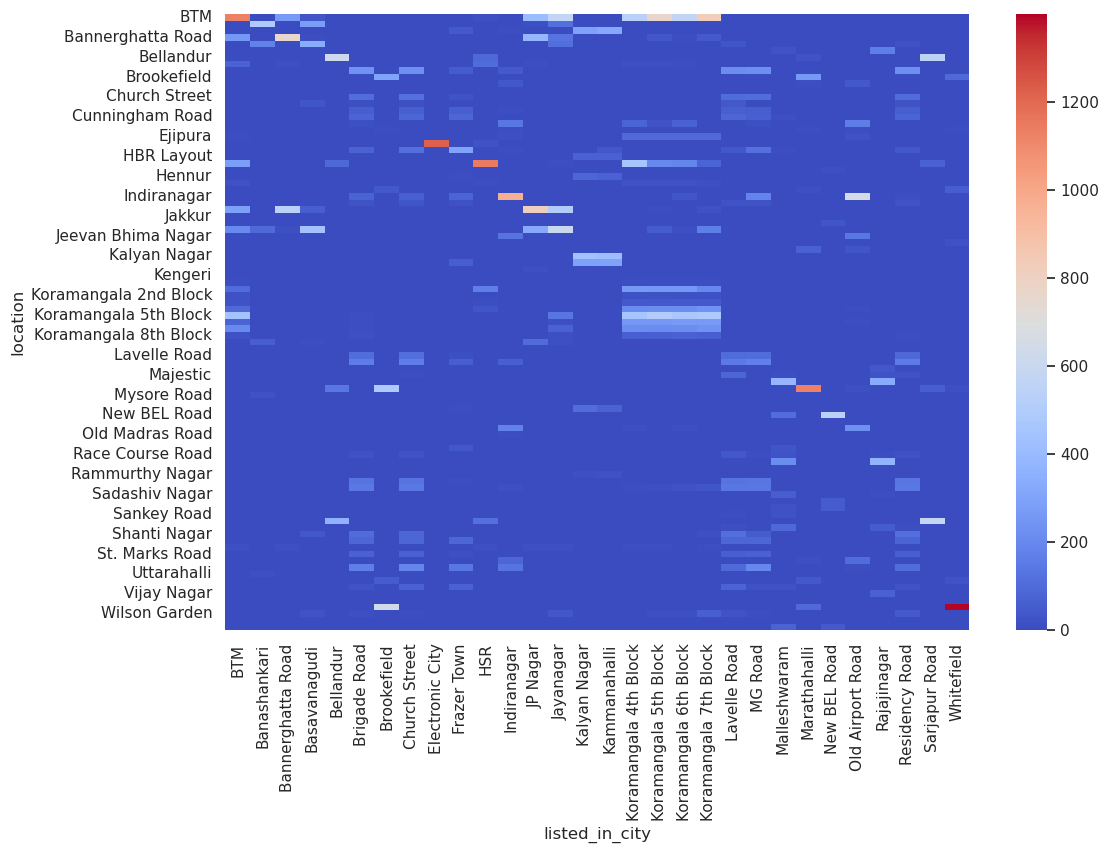

In [26]:
analyze_location_redundancy(df)

## `Converting menu_items into simple strings`

In [27]:
from typing import Any

import pandas as pd
from loguru import logger

# You must have pandarallel installed and initialized
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)


def fix_menu_list(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Robustly converts a column containing string representations of lists
    into a column of strings, making the data hashable.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to convert.

    Returns:
        pd.DataFrame: The DataFrame with the converted column.
    """
    logger.info(
        f"--- Converting column '{column_name}' from list-strings to simple strings ---"
    )

    df_cleaned = df.copy()

    def parse_and_convert(cell_str: Any) -> str:
        """
        Helper function to safely parse a string and convert it to a tuple.
        """
        # Guard against non-string data
        if not isinstance(cell_str, str):
            return "Unknown"  # Or return an empty tuple: ()

        try:

            if cell_str == "[]":
                return "Unknown"
            else:
                return cell_str.replace("[", "").replace("]", "")
        except (ValueError, SyntaxError):
            # If parsing fails, it's a malformed string
            return "Unknown"

    # Apply the robust function to the entire column
    df_cleaned[column_name] = df_cleaned[column_name].parallel_apply(parse_and_convert)

    logger.success(f"Column '{column_name}' has been converted to string.")
    return df_cleaned


# --- HOW TO USE ---
# df_cleaned = convert_list_str_to_tuple(df_cleaned, 'menu_item')

# --- VERIFICATION ---
# print(type(df_cleaned['menu_item'].dropna().iloc[0]))
# Expected output: <class 'tuple'>

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [28]:
df = fix_menu_list(df, "menu_item")

2025-08-26 18:27:23 | INFO     | __main__:fix_menu_list:24 - --- Converting column 'menu_item' from list-strings to simple strings ---


2025-08-26 18:27:24 | SUCCESS  | __main__:fix_menu_list:51 - Column 'menu_item' has been converted to string.


# `Removing every possible duplicate`

## 4. Duplicate Removal

Handling duplicates is one of the most critical steps. A simple `df.drop_duplicates()` is insufficient due to the complex, unhashable `reviews_list` column. We will implement a robust, two-stage process.

### 4.1. Stage 1: Content-Based Duplicate Removal

This function, `handle_duplicates_from_scratch`, is the core of our deduplication strategy. It identifies and removes rows that are **perfect clones**, where all metadata *and* the set of reviews are identical.

**The process is as follows:**
1.  **Parse `reviews_list`:** The string representation of reviews is converted back into a proper Python list.
2.  **Create a "Fingerprint":** For each row, a unique, hashable tuple is created from its set of reviews. This allows us to compare rows with unhashable list data.
3.  **Drop Duplicates:** The function drops rows where all columns (including the new review fingerprint) are identical.

In [29]:
import ast


# --- Helper Function 1: Convert String to List ---
def _string_to_list_parser(cell_value) -> list:
    """
    Job: Takes a value from a cell. If it's a string that looks like a list,
    it converts it to a real list. Otherwise, it returns an empty list.
    """
    # If it's already a list, we're done.
    if isinstance(cell_value, list):
        return cell_value

    # If it's a string, try to parse it.
    if isinstance(cell_value, str):
        try:
            # ast.literal_eval is the only safe way to do this.
            parsed_value = ast.literal_eval(cell_value)
            # Ensure the result is actually a list
            if isinstance(parsed_value, list):
                return parsed_value
        except (ValueError, SyntaxError):
            # If the string is malformed (e.g., contains 'nan'), it will fail.
            # Return an empty list as a fallback.
            return []

    # If it's not a list or a parsable string (e.g., NaN, empty string), return empty.
    return []


# --- Helper Function 2: Create a Fingerprint from a List ---
def _create_fingerprint_from_list(review_list: list) -> tuple:
    """
    Job: Takes a REAL Python list, cleans internal duplicates, sorts it,
    and returns a single hashable tuple to be used as a fingerprint.
    """
    # Handle the None values we know exist.
    cleaned_reviews = []
    for item in review_list:
        if isinstance(item, tuple) and len(item) == 2:
            rating, text = item
            # Explicitly replace None with a string to make sorting safe.
            final_rating = "Not Rated" if rating is None else rating
            cleaned_reviews.append((final_rating, text))

    # Remove duplicates within the list and sort to create a consistent order.
    unique_reviews = set(cleaned_reviews)
    sorted_reviews = sorted(list(unique_reviews))

    return tuple(sorted_reviews)


# --- Main Function: Written From Scratch ---
def handle_duplicates_from_scratch(df: pd.DataFrame) -> pd.DataFrame:
    """
    Follows the user's direct instructions to clean and deduplicate the data.
    """
    logger.info("--- Handling Duplicates (From Scratch Version) ---")

    # Work on a copy to be safe
    df_processed = df.copy()

    # --- STEP 1: Convert all review strings into real lists ---
    logger.info("Step 1: Parsing all 'reviews_list' cells into Python lists...")
    df_processed["reviews_list"] = df_processed["reviews_list"].apply(
        _string_to_list_parser
    )
    logger.info("Step 1 complete.")

    # --- STEP 2: Calculate initial review count from the PARSED data ---
    initial_review_count = df_processed["reviews_list"].apply(len).sum()
    logger.info(f"Step 2: Initial review count after parsing: {initial_review_count:,}")
    # If this number is low, the `ast.literal_eval` is failing because of unhandled text like 'nan'.

    # --- STEP 3: Create a fingerprint for every row ---
    logger.info(
        "Step 3: Creating a unique fingerprint for each restaurant's reviews..."
    )
    df_processed["fingerprint"] = df_processed["reviews_list"].apply(
        _create_fingerprint_from_list
    )
    logger.info("Step 3 complete.")

    # --- STEP 4: Remove duplicate rows based on the fingerprint ---
    cols_to_check = [
        col for col in df_processed.columns if col not in ["reviews_list", "url"]
    ]
    num_duplicates = df_processed.duplicated(subset=cols_to_check).sum()
    logger.info(
        f"Step 4: Found {num_duplicates:,} duplicate restaurant rows to remove."
    )

    df_final = df_processed.drop_duplicates(subset=cols_to_check, keep="first")
    logger.success(f"Successfully removed {num_duplicates:,} duplicate rows.")
    logger.info(f"DataFrame shape changed from {df.shape} to {df_final.shape}")

    # --- STEP 5: Finalize the dataframe and report metrics ---
    # The 'reviews_list' in df_final is already the fully parsed list.
    # We can efficiently get the final, clean list directly from the fingerprint column.
    df_final = df_final.copy()  # Avoid a pandas warning
    df_final["reviews_list"] = df_final["fingerprint"].apply(list)

    final_review_count = df_final["reviews_list"].apply(len).sum()
    reviews_removed = initial_review_count - final_review_count

    logger.success(
        f"Removed a total of {reviews_removed:,} reviews (from dropped rows and internal duplicates)."
    )
    logger.info(f"Final unique review count: {final_review_count:,}")

    # Drop the temporary column and return the final, clean DataFrame
    return df_final.drop(columns=["fingerprint"]).reset_index(drop=True)

In [30]:
df = handle_duplicates_from_scratch(df)

2025-08-26 18:27:24 | INFO     | __main__:handle_duplicates_from_scratch:58 - --- Handling Duplicates (From Scratch Version) ---
2025-08-26 18:27:24 | INFO     | __main__:handle_duplicates_from_scratch:64 - Step 1: Parsing all 'reviews_list' cells into Python lists...
2025-08-26 18:27:26 | INFO     | __main__:handle_duplicates_from_scratch:68 - Step 1 complete.
2025-08-26 18:27:26 | INFO     | __main__:handle_duplicates_from_scratch:72 - Step 2: Initial review count after parsing: 1,320,051
2025-08-26 18:27:26 | INFO     | __main__:handle_duplicates_from_scratch:76 - Step 3: Creating a unique fingerprint for each restaurant's reviews...
2025-08-26 18:27:26 | INFO     | __main__:handle_duplicates_from_scratch:82 - Step 3 complete.
2025-08-26 18:27:27 | INFO     | __main__:handle_duplicates_from_scratch:89 - Step 4: Found 47 duplicate restaurant rows to remove.
2025-08-26 18:27:27 | SUCCESS  | __main__:handle_duplicates_from_scratch:94 - Successfully removed 47 duplicate rows.
2025-08-26

### 4.2. Stage 2: Merging Metadata Clones

After removing perfect clones, we discovered a more subtle issue: "metadata clones." These are rows with identical metadata (name, address, rate, etc.) but *different* review lists. This suggests a single restaurant was scraped multiple times, capturing different sets of reviews.

This function performs a **targeted surgical merge**:
1.  **Identify:** It uses `df.duplicated(subset=metadata_cols, keep=False)` to find only the groups of metadata clones.
2.  **Isolate:** It separates these clone groups from the vast majority of unique rows.
3.  **Merge:** It merges *only* the clone groups, combining their review lists using a set union to create one complete, unique list of reviews.
4.  **Recombine:** It rejoins the newly merged rows with the original unique rows.

In [31]:
import pandas as pd


def targeted_merge_clones(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs a targeted merge of metadata clones without affecting unique rows.

    Args:
        df (pd.DataFrame): The DataFrame after initial duplicate removal
                           (e.g., the output of handle_duplicates_from_scratch).

    Returns:
        pd.DataFrame: A new DataFrame with only the true metadata clones merged.
    """
    logger.info("--- Starting Targeted Merge of Metadata Clones ---")

    # 1. Define the columns that identify a unique restaurant's metadata.
    metadata_cols = [
        "address",
        "name",
        "online_order",
        "book_table",
        "rate",
        "votes",
        "phone",
        "location",
        "rest_type",
        "dish_liked",
        "cuisines",
        "cost_for_two",
        "menu_item",
        "listed_in_type",
        "listed_in_city",
    ]

    # 2. Identify ALL rows that are part of a metadata duplicate group.
    #    `keep=False` marks all occurrences of duplicates as True.
    clone_mask = df.duplicated(subset=metadata_cols, keep=False)

    # If no clones are found, there's nothing to do.
    if not clone_mask.any():
        logger.success(
            "No metadata clones found to merge. DataFrame is already fully unique."
        )
        return df

    # 3. Isolate the two parts of the DataFrame.
    #    - `df_clones`: The small set of rows that need to be merged.
    #    - `df_unique`: The vast majority of rows that are already unique and safe.
    df_clones = df[clone_mask]
    df_unique = df[~clone_mask]

    logger.info(
        f"Identified {len(df_clones)} rows belonging to {df_clones.duplicated(subset=metadata_cols).sum()} clone groups."
    )
    logger.info(f"Temporarily setting aside {len(df_unique)} unique rows.")

    # 4. Perform the merge operation ONLY on the isolated clones.
    #    This is the surgical `groupby` that is now safe.
    logger.info("Merging the isolated clone groups...")
    df_merged_clones = (
        df_clones.groupby(metadata_cols)
        .agg(
            {"reviews_list": "sum", "url": "first"}  # Concatenate lists  # Keep one URL
        )
        .reset_index()
    )

    # 5. Apply the "set union" to the newly merged review lists to remove duplicates.
    def get_unique_reviews(concatenated_list):
        return sorted(list(set(concatenated_list)))

    df_merged_clones["reviews_list"] = df_merged_clones["reviews_list"].apply(
        get_unique_reviews
    )

    logger.info("Successfully merged clones into unique rows.")

    # 6. Recombine the merged clones with the untouched unique rows.
    #    `pd.concat` is the function to stack DataFrames on top of each other.
    logger.info("Recombining merged rows with the original unique rows...")
    df_final = pd.concat([df_unique, df_merged_clones], ignore_index=True)

    logger.success("Targeted merge complete!")
    logger.info(
        f"Final DataFrame shape is {df_final.shape}. (Expected change: {df.shape[0]} -> {df_final.shape[0]})"
    )

    return df_final

In [32]:
df = targeted_merge_clones(df)

# This is your final, ultimate dataset.
print("\n--- Final, Fully Cleaned DataFrame Info ---")
df.info()
print(f"\nFinal Shape: {df.shape}")

2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:15 - --- Starting Targeted Merge of Metadata Clones ---
2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:53 - Identified 26 rows belonging to 13 clone groups.
2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:56 - Temporarily setting aside 51644 unique rows.
2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:60 - Merging the isolated clone groups...
2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:77 - Successfully merged clones into unique rows.
2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:81 - Recombining merged rows with the original unique rows...
2025-08-26 18:27:27 | SUCCESS  | __main__:targeted_merge_clones:84 - Targeted merge complete!
2025-08-26 18:27:27 | INFO     | __main__:targeted_merge_clones:85 - Final DataFrame shape is (51656, 17). (Expected change: 51670 -> 51656)

--- Final, Fully Cleaned DataFrame Info ---
<class 'pandas.core.fr

## 5. Missing Value Imputation

With a fully deduplicated dataset, we can now confidently address the missing values. Our strategy prioritizes data integrity and uses context-aware methods.

**The Strategic Order of Operations:**
1.  **Initial Cleanup:** Drop rows where both `rate` and `reviews_list` are missing, as these are unsalvageable. We also drop the `phone` column as it provides little value for our predictive goal.
2.  **Fill `dish_liked`:** This column has the most missing values. We fill them with the string `"Unknown"`, treating the absence of liked dishes as a distinct piece of information.
3.  **Impute `rest_type`:** We use the `listed_in_type` column as a guide, mapping dining types (e.g., 'Delivery') to the most likely restaurant type (e.g., 'Quick Bites').
4.  **Impute `cuisines`:** We use an advanced KNN-style approach, finding the most similar restaurants based on `location` and `rest_type` and using their most common cuisine to fill the missing value.
5.  **Rescue `rate`:** This is the most critical imputation. For rows with a missing `rate` but an existing `reviews_list`, we calculate the average rating from the reviews and use it to fill the missing value. This "great rescue" salvages thousands of valuable rows.
6.  **Impute `cost_for_two`:** Finally, we use another advanced similarity engine. It finds the most similar restaurants based on a weighted score of `rate`, `votes`, `rest_type`, and `cuisines` within the same `location`, and uses their median cost to impute the final missing values.

In [33]:
# Get the count of missing values for every column
missing_values = df.isnull().sum()

# Print the columns that have missing values
print("--- Missing Value Report ---")
print(missing_values[missing_values > 0].sort_values(ascending=False))

--- Missing Value Report ---
dish_liked      28049
rate            10036
phone            1205
cost_for_two      343
rest_type         227
cuisines           45
location           21
dtype: int64


In [34]:
condition_one = df["rate"].isnull()
condition_two = df["reviews_list"].apply(len) == 0
df = df.drop(df[condition_one & condition_two].index, axis=0).reset_index(drop=True)

In [35]:
# Droping useless column phone
df = df.drop("phone", axis=1)

In [36]:
df["dish_liked"] = df["dish_liked"].fillna("Unknown")

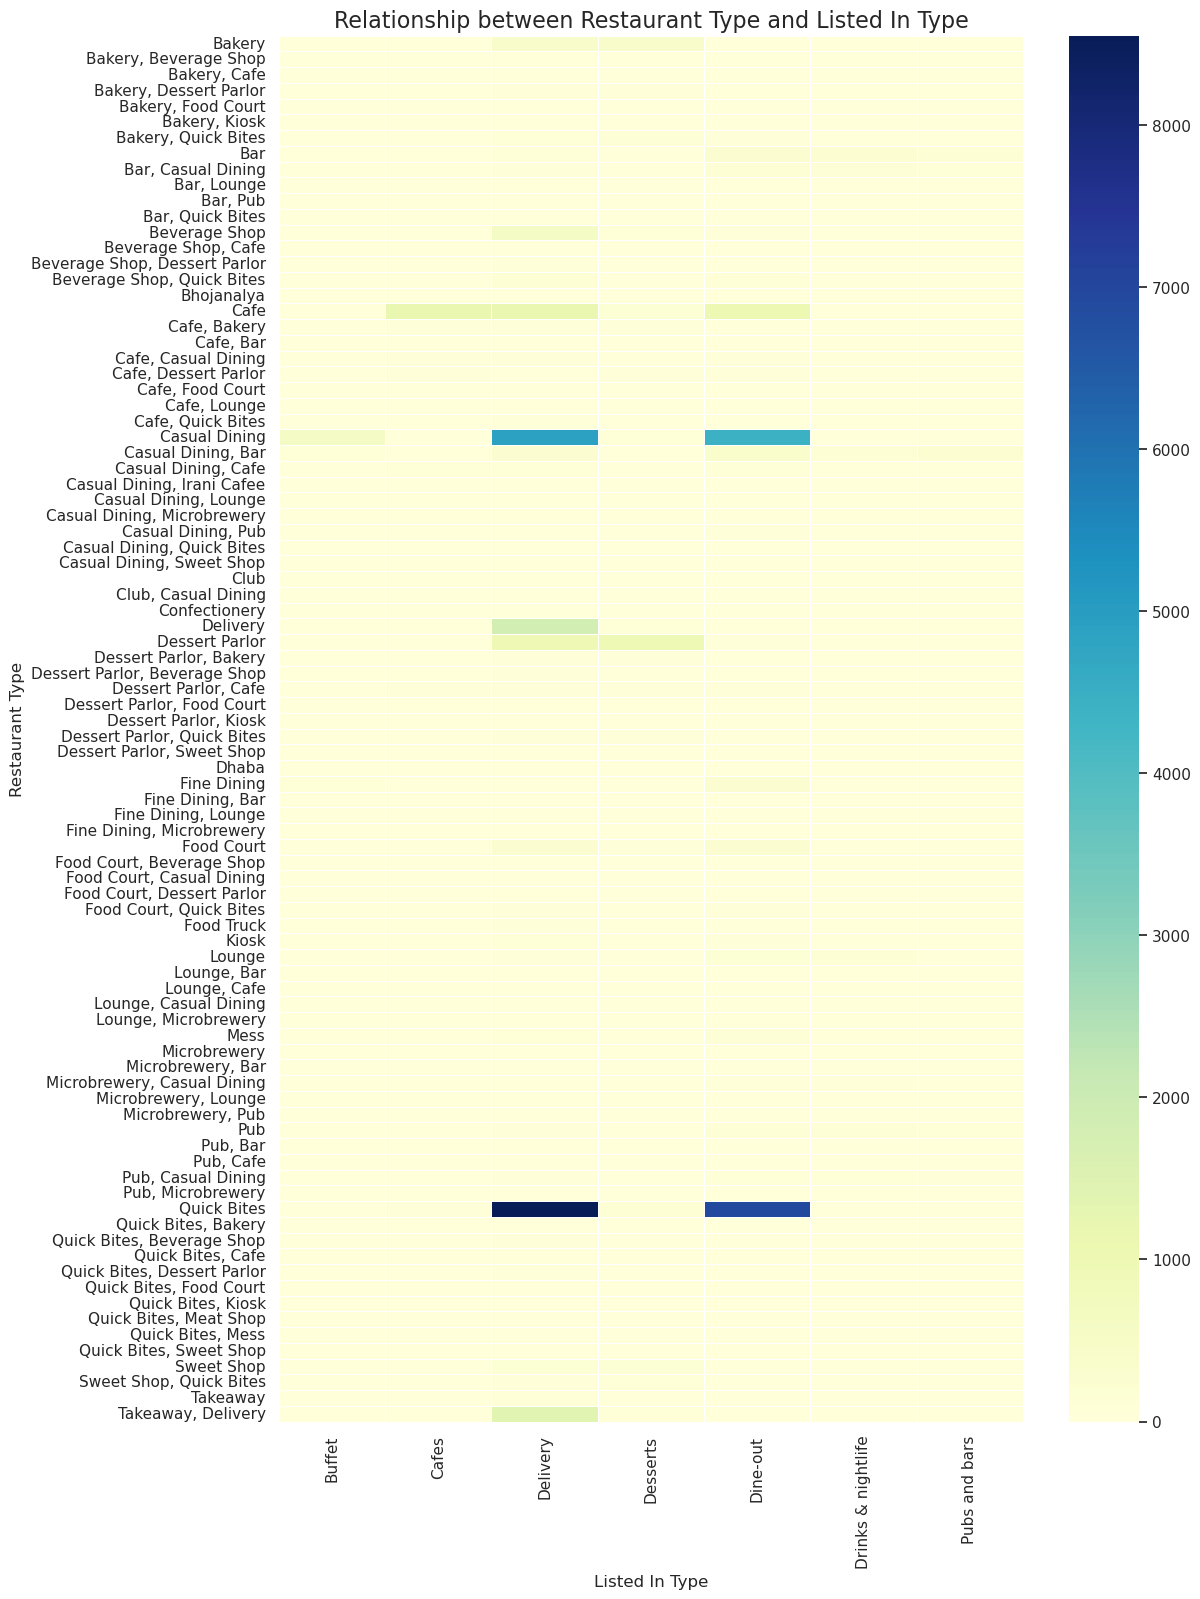

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# First, we need to get the data into a "crosstab" format, which is like a pivot table.
# This creates the grid that the heatmap needs.
crosstab_data = pd.crosstab(df["rest_type"], df["listed_in_type"])

# Now, create the heatmap
plt.figure(figsize=(12, 18))  # Adjust the size as needed to make it readable
sns.heatmap(
    crosstab_data,
    cmap="YlGnBu",  # A nice blue-green color map
    annot=False,  # We won't write the numbers on the cells, it would be too cluttered
    linewidths=0.5,
)

plt.title("Relationship between Restaurant Type and Listed In Type", fontsize=16)
plt.xlabel("Listed In Type", fontsize=12)
plt.ylabel("Restaurant Type", fontsize=12)
plt.show()

In [38]:
# Create a boolean mask to find the rows where 'rest_type' is missing
missing_rest_type_mask = df["rest_type"].isnull()

# Use this mask to select only those rows
rows_to_fix = df[missing_rest_type_mask]

# Now, from these rows, get the value counts of the 'listed_in_type' column
listed_in_type_counts = rows_to_fix["listed_in_type"].value_counts()

print("--- Report on Rows with Missing 'rest_type' ---")
print(f"Total rows to fix: {len(rows_to_fix)}")
print("\nHere are the 'listed_in_type' values for these specific rows:")
print(listed_in_type_counts)

--- Report on Rows with Missing 'rest_type' ---
Total rows to fix: 160

Here are the 'listed_in_type' values for these specific rows:
listed_in_type
Delivery    89
Dine-out    66
Desserts     5
Name: count, dtype: int64


In [40]:
from collections import Counter

import pandas as pd
from tqdm import tqdm  # A library to show progress bars, useful for long operations

# df_imputed is your DataFrame after handling 'rate', 'phone', 'dish_liked' etc.
# We'll work on a copy.


def jaccard_similarity(set1, set2):
    """Calculates the Jaccard Similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0


def impute_cuisines_knn_style(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing 'cuisines' by finding the most similar restaurants
    and using their most common cuisine.
    """
    logger.info("--- Starting Advanced KNN-style Imputation for 'cuisines' ---")

    # --- PREPARATION STEP ---
    # Convert 'rest_type' strings into sets for easy comparison. This is a one-time operation.
    # We will handle NaNs and assume comma-space separation.
    df["rest_type_set"] = (
        df["rest_type"]
        .astype(str)
        .apply(lambda x: set(s.strip() for s in x.split(",")))
    )

    # Isolate the rows we need to fix and the rows we can learn from.
    df_missing_cuisines = df[df["cuisines"].isnull()].copy()
    df_candidates = df[df["cuisines"].notnull()].copy()

    if df_missing_cuisines.empty:
        logger.success("No missing cuisines to impute.")
        return df.drop(columns=["rest_type_set"])

    logger.info(
        f"Found {len(df_missing_cuisines)} rows with missing cuisines to impute."
    )

    # --- MAIN IMPUTATION LOOP ---
    # We will iterate through each row that needs a cuisine value.
    # tqdm will give us a nice progress bar.
    for index, target_row in tqdm(
        df_missing_cuisines.iterrows(),
        total=len(df_missing_cuisines),
        desc="Imputing Cuisines",
    ):
        # --- Find Similar Neighbors ---
        # First, dramatically filter candidates to the same location for speed and relevance.
        location_candidates = df_candidates[
            df_candidates["location"] == target_row["location"]
        ]

        # If no candidates in the same location, use the whole pool (rare fallback)
        if location_candidates.empty:
            location_candidates = df_candidates

        scores = []
        for _, candidate_row in location_candidates.iterrows():
            # Calculate the similarity score
            jaccard_score = jaccard_similarity(
                target_row["rest_type_set"], candidate_row["rest_type_set"]
            )
            type_match_score = (
                1
                if target_row["listed_in_type"] == candidate_row["listed_in_type"]
                else 0
            )

            # Combine scores (giving more weight to Jaccard similarity)
            total_score = (2 * jaccard_score) + type_match_score
            scores.append((total_score, candidate_row["cuisines"]))

        # Get the top 5 neighbors with the highest scores
        scores.sort(key=lambda x: x[0], reverse=True)
        top_k_neighbors = scores[:5]

        # --- Aggregate Cuisines from Neighbors ---
        if not top_k_neighbors:
            continue  # Should not happen if we have candidates

        all_cuisines = []
        for score, cuisines_str in top_k_neighbors:
            # Split the string and add to the big list
            all_cuisines.extend([c.strip() for c in cuisines_str.split(",")])

        # Find the single most common cuisine
        if all_cuisines:
            most_common_cuisine = Counter(all_cuisines).most_common(1)[0][0]
        else:
            most_common_cuisine = "Unknown"  # Fallback if neighbors have no cuisines

        # --- Update the DataFrame ---
        # Use .loc to safely update the original DataFrame
        df.loc[index, "cuisines"] = most_common_cuisine

    logger.success("KNN-style imputation for 'cuisines' is complete.")

    # Clean up the helper column before returning
    return df.drop(columns=["rest_type_set"])


# --- Execute the plan ---
df = impute_cuisines_knn_style(df)

# --- Check the result ---
print("\n--- Final Check After Cuisine Imputation ---")
print(df.isnull().sum())

2025-08-26 18:27:28 | INFO     | __main__:impute_cuisines_knn_style:22 - --- Starting Advanced KNN-style Imputation for 'cuisines' ---
2025-08-26 18:27:28 | INFO     | __main__:impute_cuisines_knn_style:41 - Found 17 rows with missing cuisines to impute.


Imputing Cuisines: 100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 27.61it/s]

2025-08-26 18:27:29 | SUCCESS  | __main__:impute_cuisines_knn_style:102 - KNN-style imputation for 'cuisines' is complete.

--- Final Check After Cuisine Imputation ---
url                  0
address              0
name                 0
online_order         0
book_table           0
rate              3567
votes                0
location             0
rest_type            0
dish_liked           0
cuisines             0
cost_for_two       295
reviews_list         0
menu_item            0
listed_in_type       0
listed_in_city       0
dtype: int64


In [39]:
import numpy as np
import pandas as pd

imputation_map = {
    "Delivery": "Quick Bites",
    "Dine-out": "Quick Bites",
    "Desserts": "Dessert Parlor",
}

# --- The High-Performance Method ---

# 1. Create a boolean mask to identify ONLY the rows we need to fix.
#    This is much more efficient than processing the whole DataFrame.
mask_to_fix = df["rest_type"].isnull()

# 2. On just these target rows, get the 'listed_in_type' column.
#    This is a small Series of only 160 values.
values_to_map = df.loc[mask_to_fix, "listed_in_type"]

# 3. Use the super-fast .map() method to get the new values.
#    .map() is designed for this exact task: converting values in a Series
#    using a dictionary (our imputation_map).
new_values = values_to_map.map(imputation_map)

# 4. Use .loc with the mask to fill the NaNs in 'rest_type' with the new values.
#    This is a direct, fast assignment that only touches the necessary cells.
df.loc[mask_to_fix, "rest_type"] = new_values

print("Successfully imputed 'rest_type' using the high-performance .map() method.")

# --- Verification (Same as before) ---
print("\n--- Missing values check for 'rest_type' after imputation ---")
print(f"Missing values in 'rest_type': {df['rest_type'].isnull().sum()}")

Successfully imputed 'rest_type' using the high-performance .map() method.

--- Missing values check for 'rest_type' after imputation ---
Missing values in 'rest_type': 0


In [41]:
import logging
import re

import numpy as np
import pandas as pd

# Assume logger and _calculate_mean_from_reviews are already defined


def _calculate_mean_from_reviews(review_list: list) -> float:
    """
    Extracts all numeric ratings from a list of review tuples and calculates their mean.
    """
    if not isinstance(review_list, list) or not review_list:
        return np.nan
    ratings = []
    for review_tuple in review_list:
        rating_str = review_tuple[0]
        match = re.search(r"(\d+\.\d+)", str(rating_str))
        if match:
            ratings.append(float(match.group(1)))
    if ratings:
        return np.mean(ratings)
    else:
        return np.nan


def impute_rate_with_review_avg(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing 'rate' values by applying the review averaging logic.
    It will first try to fill from reviews, then drop any rows that are still missing a rate.

    Args:
        df (pd.DataFrame): The DataFrame with missing 'rate' values.

    Returns:
        pd.DataFrame: A new DataFrame with 'rate' imputed and unsalvageable rows dropped.
    """
    logger.info("--- Starting 'rate' imputation via review averaging ---")

    df_imputed = df.copy()

    # --- Step 1: The Great Rescue ---
    logger.info("Step 1: Calculating average ratings from review lists...")
    calculated_rates = df_imputed["reviews_list"].apply(_calculate_mean_from_reviews)

    # --- THIS IS THE FIX ---
    # Instead of using inplace=True, we assign the result directly back to the column.
    # This is the modern, recommended way to do it.
    original_nan_count = df_imputed["rate"].isnull().sum()
    df_imputed["rate"] = df_imputed["rate"].fillna(calculated_rates)
    # -----------------------

    rescued_count = original_nan_count - df_imputed["rate"].isnull().sum()
    logger.success(
        f"Rate Rescue Complete. Rescued {rescued_count} of {original_nan_count} missing values."
    )

    # --- Step 2: Drop the Unsalvageable ---
    logger.info("Step 2: Dropping any rows where 'rate' is still missing...")
    initial_rows = len(df_imputed)
    df_imputed.dropna(subset=["rate"], inplace=True)
    rows_dropped = initial_rows - len(df_imputed)

    if rows_dropped > 0:
        logger.warning(f"Dropped {rows_dropped} unsalvageable rows.")
    else:
        logger.success("No unsalvageable rows needed to be dropped.")

    logger.info(
        f"Final training set size after rate imputation: {len(df_imputed)} rows."
    )

    return df_imputed

In [42]:
df = impute_rate_with_review_avg(df)

print("\n--- Final Check ---")
print(df.isnull().sum())  # Should be 0

2025-08-26 18:27:29 | INFO     | __main__:impute_rate_with_review_avg:39 - --- Starting 'rate' imputation via review averaging ---
2025-08-26 18:27:29 | INFO     | __main__:impute_rate_with_review_avg:44 - Step 1: Calculating average ratings from review lists...
2025-08-26 18:27:29 | SUCCESS  | __main__:impute_rate_with_review_avg:55 - Rate Rescue Complete. Rescued 3567 of 3567 missing values.
2025-08-26 18:27:29 | INFO     | __main__:impute_rate_with_review_avg:60 - Step 2: Dropping any rows where 'rate' is still missing...
2025-08-26 18:27:29 | SUCCESS  | __main__:impute_rate_with_review_avg:68 - No unsalvageable rows needed to be dropped.
2025-08-26 18:27:29 | INFO     | __main__:impute_rate_with_review_avg:70 - Final training set size after rate imputation: 45187 rows.

--- Final Check ---
url                 0
address             0
name                0
online_order        0
book_table          0
rate                0
votes               0
location            0
rest_type          

In [43]:
import logging

import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm import tqdm

# Initialize pandarallel (run once)
try:
    pandarallel.initialize(progress_bar=True, verbose=0)
    # logger.info("Pandarallel initialized successfully.")
except Exception:
    # logger.warning("Pandarallel could not be initialized. Falling back to standard apply.")
    pass


def impute_cost_with_similarity_engine_fixed(
    df: pd.DataFrame, k_neighbors: int = 7
) -> pd.DataFrame:
    """
    Imputes 'cost_for_two' using a targeted, parallelized similarity engine.
    This version nests helper functions to ensure they are available to parallel workers.
    """
    logger.info(
        "--- Starting Final Optimized Similarity-Based Imputation (Parallel-Safe) ---"
    )

    # --- NESTED HELPER FUNCTIONS (THE FIX) ---
    # By defining these inside, they are "shipped" with the main function to each parallel worker.

    def jaccard_similarity_sets(set1, set2):
        if not set1 and not set2:
            return 1.0
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union != 0 else 0

    def weighted_rating_similarity(rate1, votes1, rate2, votes2):
        rating_similarity = 1 - (abs(rate1 - rate2) / 4.0)
        confidence_weight = np.log1p(min(votes1, votes2))
        return rating_similarity * confidence_weight

    # ----------------------------------------------

    df_imputed = df.copy()

    # --- Step 1: Preparation ---
    logger.info("Step 1: Pre-computing feature sets...")
    df_imputed["rest_type_set"] = (
        df_imputed["rest_type"]
        .astype(str)
        .apply(lambda x: set(s.strip() for s in x.split(",")))
    )
    df_imputed["cuisines_set"] = (
        df_imputed["cuisines"]
        .astype(str)
        .apply(lambda x: set(s.strip() for s in x.split(",")))
    )

    df_missing = df_imputed[df_imputed["cost_for_two"].isnull()]
    df_candidates = df_imputed[df_imputed["cost_for_two"].notnull()]

    if df_missing.empty:
        logger.success("No missing values to impute.")
        return df.drop(columns=["rest_type_set", "cuisines_set"], errors="ignore")

    logger.info(
        f"Found {len(df_missing)} rows to impute using {len(df_candidates)} candidates."
    )

    # --- Step 2: Main Imputation Loop ---
    logger.info("Step 2: Beginning main imputation loop...")

    for index, target_row in tqdm(
        df_missing.iterrows(), total=len(df_missing), desc="Imputing Cost"
    ):

        location_candidates = df_candidates[
            df_candidates["location"] == target_row["location"]
        ]
        if location_candidates.empty:
            location_candidates = df_candidates

        rating_similarity = location_candidates.parallel_apply(
            lambda x: weighted_rating_similarity(
                target_row["rate"], target_row["votes"], x["rate"], x["votes"]
            ),
            axis=1,
        )
        rest_type_jaccard = location_candidates["rest_type_set"].parallel_apply(
            lambda x: jaccard_similarity_sets(x, target_row["rest_type_set"])
        )
        cuisines_jaccard = location_candidates["cuisines_set"].parallel_apply(
            lambda x: jaccard_similarity_sets(x, target_row["cuisines_set"])
        )

        type_match = (
            location_candidates["listed_in_type"] == target_row["listed_in_type"]
        ).astype(int)

        total_score = (
            (5 * rating_similarity)
            + (4 * rest_type_jaccard)
            + (2 * cuisines_jaccard)
            + (1 * type_match)
        )

        top_k_indices = total_score.nlargest(k_neighbors).index
        neighbor_costs = location_candidates.loc[top_k_indices, "cost_for_two"]
        imputed_value = neighbor_costs.median()

        if pd.isnull(imputed_value):
            imputed_value = df_candidates["cost_for_two"].median()

        df_imputed.loc[index, "cost_for_two"] = imputed_value

    # --- Step 3: Cleanup ---
    logger.info("Step 3: Cleaning up helper columns...")
    df_imputed.drop(
        columns=["rest_type_set", "cuisines_set"], inplace=True, errors="ignore"
    )

    final_missing_count = df_imputed["cost_for_two"].isnull().sum()
    if final_missing_count == 0:
        logger.success(
            "Optimized similarity imputation complete. All missing values filled."
        )
    else:
        logger.error(
            f"Imputation FAILED. {final_missing_count} values are still missing."
        )

    return df_imputed

In [44]:
df = impute_cost_with_similarity_engine_fixed(df)

2025-08-26 18:27:29 | INFO     | __main__:impute_cost_with_similarity_engine_fixed:24 - --- Starting Final Optimized Similarity-Based Imputation (Parallel-Safe) ---
2025-08-26 18:27:29 | INFO     | __main__:impute_cost_with_similarity_engine_fixed:48 - Step 1: Pre-computing feature sets...
2025-08-26 18:27:30 | INFO     | __main__:impute_cost_with_similarity_engine_fixed:67 - Found 295 rows to impute using 44892 candidates.
2025-08-26 18:27:30 | INFO     | __main__:impute_cost_with_similarity_engine_fixed:72 - Step 2: Beginning main imputation loop...


Imputing Cost:   0%|                                                       | 0/295 [00:00<?, ?it/s]

Imputing Cost:   0%|▏                                              | 1/295 [00:01<05:51,  1.20s/it]

Imputing Cost:   1%|▎                                              | 2/295 [00:02<05:34,  1.14s/it]

Imputing Cost:   1%|▍                                              | 3/295 [00:03<05:30,  1.13s/it]

Imputing Cost:   1%|▋                                              | 4/295 [00:04<05:46,  1.19s/it]

Imputing Cost:   2%|▊                                              | 5/295 [00:05<05:52,  1.22s/it]

Imputing Cost:   2%|▉                                              | 6/295 [00:07<05:49,  1.21s/it]

Imputing Cost:   2%|█                                              | 7/295 [00:08<05:54,  1.23s/it]

Imputing Cost:   3%|█▎                                             | 8/295 [00:09<05:49,  1.22s/it]

Imputing Cost:   3%|█▍                                             | 9/295 [00:10<05:41,  1.19s/it]

Imputing Cost:   4%|█▋                                            | 11/295 [00:11<03:36,  1.31it/s]

Imputing Cost:   4%|█▊                                            | 12/295 [00:12<04:05,  1.15it/s]

Imputing Cost:   4%|██                                            | 13/295 [00:13<04:35,  1.02it/s]

Imputing Cost:   5%|██▏                                           | 14/295 [00:15<04:54,  1.05s/it]

Imputing Cost:   5%|██▎                                           | 15/295 [00:16<05:59,  1.28s/it]

Imputing Cost:   5%|██▍                                           | 16/295 [00:18<05:46,  1.24s/it]

Imputing Cost:   6%|██▋                                           | 17/295 [00:19<05:38,  1.22s/it]

Imputing Cost:   6%|██▊                                           | 18/295 [00:20<05:41,  1.23s/it]

Imputing Cost:   6%|██▉                                           | 19/295 [00:21<05:47,  1.26s/it]

Imputing Cost:   7%|███                                           | 20/295 [00:23<05:50,  1.27s/it]

Imputing Cost:   7%|███▎                                          | 21/295 [00:24<05:52,  1.29s/it]

Imputing Cost:   7%|███▍                                          | 22/295 [00:25<05:53,  1.29s/it]

Imputing Cost:   8%|███▌                                          | 23/295 [00:26<05:39,  1.25s/it]

Imputing Cost:   8%|███▋                                          | 24/295 [00:28<05:38,  1.25s/it]

Imputing Cost:   8%|███▉                                          | 25/295 [00:29<05:36,  1.25s/it]

Imputing Cost:   9%|████                                          | 26/295 [00:30<05:36,  1.25s/it]

Imputing Cost:   9%|████▏                                         | 27/295 [00:31<05:33,  1.25s/it]

Imputing Cost:   9%|████▎                                         | 28/295 [00:33<05:34,  1.25s/it]

Imputing Cost:  10%|████▌                                         | 29/295 [00:34<05:47,  1.31s/it]

Imputing Cost:  10%|████▋                                         | 30/295 [00:36<06:02,  1.37s/it]

Imputing Cost:  11%|████▊                                         | 31/295 [00:37<06:18,  1.43s/it]

Imputing Cost:  11%|████▉                                         | 32/295 [00:39<06:12,  1.42s/it]

Imputing Cost:  11%|█████▏                                        | 33/295 [00:40<06:16,  1.44s/it]

Imputing Cost:  12%|█████▎                                        | 34/295 [00:41<06:02,  1.39s/it]

Imputing Cost:  12%|█████▌                                        | 36/295 [00:43<04:29,  1.04s/it]

Imputing Cost:  13%|█████▊                                        | 37/295 [00:44<05:10,  1.20s/it]

Imputing Cost:  13%|█████▉                                        | 38/295 [00:46<05:35,  1.30s/it]

Imputing Cost:  13%|██████                                        | 39/295 [00:47<05:33,  1.30s/it]

Imputing Cost:  14%|██████▏                                       | 40/295 [00:48<05:30,  1.30s/it]

Imputing Cost:  14%|██████▍                                       | 41/295 [00:50<05:32,  1.31s/it]

Imputing Cost:  14%|██████▌                                       | 42/295 [00:51<05:17,  1.25s/it]

Imputing Cost:  15%|██████▋                                       | 43/295 [00:52<05:10,  1.23s/it]

Imputing Cost:  15%|██████▊                                       | 44/295 [00:53<05:12,  1.24s/it]

Imputing Cost:  15%|███████                                       | 45/295 [00:55<05:09,  1.24s/it]

Imputing Cost:  16%|███████▏                                      | 46/295 [00:56<05:06,  1.23s/it]

Imputing Cost:  16%|███████▎                                      | 47/295 [00:57<05:06,  1.24s/it]

Imputing Cost:  16%|███████▍                                      | 48/295 [00:58<05:02,  1.22s/it]

Imputing Cost:  17%|███████▋                                      | 49/295 [00:59<04:54,  1.20s/it]

Imputing Cost:  17%|███████▊                                      | 50/295 [01:01<05:23,  1.32s/it]

Imputing Cost:  17%|███████▉                                      | 51/295 [01:02<05:32,  1.36s/it]

Imputing Cost:  18%|████████                                      | 52/295 [01:04<05:22,  1.33s/it]

Imputing Cost:  18%|████████▎                                     | 53/295 [01:05<05:16,  1.31s/it]

Imputing Cost:  18%|████████▍                                     | 54/295 [01:06<05:09,  1.29s/it]

Imputing Cost:  19%|████████▌                                     | 55/295 [01:07<05:09,  1.29s/it]

Imputing Cost:  19%|████████▋                                     | 56/295 [01:09<05:12,  1.31s/it]

Imputing Cost:  19%|████████▉                                     | 57/295 [01:10<05:12,  1.31s/it]

Imputing Cost:  20%|█████████                                     | 58/295 [01:11<05:09,  1.30s/it]

Imputing Cost:  20%|█████████▎                                    | 60/295 [01:12<03:31,  1.11it/s]

Imputing Cost:  21%|█████████▌                                    | 61/295 [01:13<03:48,  1.02it/s]

Imputing Cost:  21%|█████████▋                                    | 62/295 [01:15<04:01,  1.04s/it]

Imputing Cost:  21%|█████████▊                                    | 63/295 [01:16<04:11,  1.08s/it]

Imputing Cost:  22%|█████████▉                                    | 64/295 [01:17<04:20,  1.13s/it]

Imputing Cost:  22%|██████████▏                                   | 65/295 [01:18<04:32,  1.18s/it]

Imputing Cost:  22%|██████████▎                                   | 66/295 [01:20<04:37,  1.21s/it]

Imputing Cost:  23%|██████████▍                                   | 67/295 [01:21<04:36,  1.21s/it]

Imputing Cost:  23%|██████████▌                                   | 68/295 [01:22<04:37,  1.22s/it]

Imputing Cost:  23%|██████████▊                                   | 69/295 [01:23<04:39,  1.24s/it]

Imputing Cost:  24%|██████████▉                                   | 70/295 [01:25<04:35,  1.23s/it]

Imputing Cost:  24%|███████████                                   | 71/295 [01:26<04:38,  1.24s/it]

Imputing Cost:  24%|███████████▏                                  | 72/295 [01:27<04:34,  1.23s/it]

Imputing Cost:  25%|███████████▍                                  | 73/295 [01:28<04:31,  1.22s/it]

Imputing Cost:  25%|███████████▌                                  | 74/295 [01:30<04:31,  1.23s/it]

Imputing Cost:  25%|███████████▋                                  | 75/295 [01:31<04:25,  1.21s/it]

Imputing Cost:  26%|███████████▊                                  | 76/295 [01:32<04:20,  1.19s/it]

Imputing Cost:  26%|████████████                                  | 77/295 [01:33<04:30,  1.24s/it]

Imputing Cost:  26%|████████████▏                                 | 78/295 [01:35<04:32,  1.25s/it]

Imputing Cost:  27%|████████████▎                                 | 79/295 [01:36<04:39,  1.30s/it]

Imputing Cost:  27%|████████████▍                                 | 80/295 [01:37<04:45,  1.33s/it]

Imputing Cost:  27%|████████████▋                                 | 81/295 [01:39<04:38,  1.30s/it]

Imputing Cost:  28%|████████████▊                                 | 82/295 [01:40<04:29,  1.27s/it]

Imputing Cost:  28%|████████████▉                                 | 83/295 [01:41<04:30,  1.27s/it]

Imputing Cost:  28%|█████████████                                 | 84/295 [01:42<04:36,  1.31s/it]

Imputing Cost:  29%|█████████████▍                                | 86/295 [01:44<03:37,  1.04s/it]

Imputing Cost:  29%|█████████████▌                                | 87/295 [01:45<03:48,  1.10s/it]

Imputing Cost:  30%|█████████████▋                                | 88/295 [01:47<04:30,  1.31s/it]

Imputing Cost:  30%|█████████████▉                                | 89/295 [01:49<04:59,  1.45s/it]

Imputing Cost:  31%|██████████████                                | 90/295 [01:51<05:10,  1.51s/it]

Imputing Cost:  31%|██████████████▏                               | 91/295 [01:52<05:14,  1.54s/it]

Imputing Cost:  31%|██████████████▎                               | 92/295 [01:54<05:19,  1.57s/it]

Imputing Cost:  32%|██████████████▌                               | 93/295 [01:56<05:55,  1.76s/it]

Imputing Cost:  32%|██████████████▋                               | 94/295 [01:58<05:47,  1.73s/it]

Imputing Cost:  32%|██████████████▊                               | 95/295 [01:59<05:40,  1.70s/it]

Imputing Cost:  33%|██████████████▉                               | 96/295 [02:01<05:28,  1.65s/it]

Imputing Cost:  33%|███████████████▏                              | 97/295 [02:02<05:12,  1.58s/it]

Imputing Cost:  33%|███████████████▎                              | 98/295 [02:04<05:04,  1.55s/it]

Imputing Cost:  34%|███████████████▍                              | 99/295 [02:05<04:58,  1.52s/it]

Imputing Cost:  34%|███████████████▎                             | 100/295 [02:07<04:59,  1.54s/it]

Imputing Cost:  34%|███████████████▍                             | 101/295 [02:08<04:57,  1.54s/it]

Imputing Cost:  35%|███████████████▌                             | 102/295 [02:10<04:54,  1.52s/it]

Imputing Cost:  35%|███████████████▋                             | 103/295 [02:11<04:44,  1.48s/it]

Imputing Cost:  35%|███████████████▊                             | 104/295 [02:13<04:45,  1.49s/it]

Imputing Cost:  36%|████████████████▏                            | 106/295 [02:14<03:24,  1.08s/it]

Imputing Cost:  36%|████████████████▎                            | 107/295 [02:15<03:41,  1.18s/it]

Imputing Cost:  37%|████████████████▍                            | 108/295 [02:17<03:57,  1.27s/it]

Imputing Cost:  37%|████████████████▋                            | 109/295 [02:18<04:04,  1.32s/it]

Imputing Cost:  37%|████████████████▊                            | 110/295 [02:20<04:10,  1.36s/it]

Imputing Cost:  38%|████████████████▉                            | 111/295 [02:21<04:17,  1.40s/it]

Imputing Cost:  38%|█████████████████                            | 112/295 [02:23<04:27,  1.46s/it]

Imputing Cost:  38%|█████████████████▏                           | 113/295 [02:25<04:32,  1.50s/it]

Imputing Cost:  39%|█████████████████▍                           | 114/295 [02:26<04:31,  1.50s/it]

Imputing Cost:  39%|█████████████████▌                           | 115/295 [02:27<04:24,  1.47s/it]

Imputing Cost:  39%|█████████████████▋                           | 116/295 [02:29<04:21,  1.46s/it]

Imputing Cost:  40%|█████████████████▊                           | 117/295 [02:30<04:19,  1.46s/it]

Imputing Cost:  40%|██████████████████                           | 118/295 [02:32<04:24,  1.50s/it]

Imputing Cost:  40%|██████████████████▏                          | 119/295 [02:33<04:24,  1.50s/it]

Imputing Cost:  41%|██████████████████▎                          | 120/295 [02:35<04:20,  1.49s/it]

Imputing Cost:  41%|██████████████████▍                          | 121/295 [02:36<04:19,  1.49s/it]

Imputing Cost:  41%|██████████████████▌                          | 122/295 [02:38<04:20,  1.51s/it]

Imputing Cost:  42%|██████████████████▊                          | 123/295 [02:40<04:22,  1.52s/it]

Imputing Cost:  42%|██████████████████▉                          | 124/295 [02:41<04:20,  1.52s/it]

Imputing Cost:  42%|███████████████████                          | 125/295 [02:43<04:19,  1.53s/it]

Imputing Cost:  43%|███████████████████▎                         | 127/295 [02:44<03:03,  1.09s/it]

Imputing Cost:  43%|███████████████████▌                         | 128/295 [02:45<03:20,  1.20s/it]

Imputing Cost:  44%|███████████████████▋                         | 129/295 [02:47<03:29,  1.27s/it]

Imputing Cost:  44%|███████████████████▊                         | 130/295 [02:48<03:42,  1.35s/it]

Imputing Cost:  44%|███████████████████▉                         | 131/295 [02:50<03:49,  1.40s/it]

Imputing Cost:  45%|████████████████████▏                        | 132/295 [02:51<03:50,  1.42s/it]

Imputing Cost:  45%|████████████████████▎                        | 133/295 [02:53<03:58,  1.47s/it]

Imputing Cost:  45%|████████████████████▍                        | 134/295 [02:55<04:03,  1.51s/it]

Imputing Cost:  46%|████████████████████▌                        | 135/295 [02:56<04:02,  1.51s/it]

Imputing Cost:  46%|████████████████████▋                        | 136/295 [02:58<04:01,  1.52s/it]

Imputing Cost:  46%|████████████████████▉                        | 137/295 [02:59<03:58,  1.51s/it]

Imputing Cost:  47%|█████████████████████                        | 138/295 [03:00<03:53,  1.48s/it]

Imputing Cost:  47%|█████████████████████▏                       | 139/295 [03:02<03:55,  1.51s/it]

Imputing Cost:  47%|█████████████████████▎                       | 140/295 [03:04<03:57,  1.53s/it]

Imputing Cost:  48%|█████████████████████▌                       | 141/295 [03:05<03:59,  1.55s/it]

Imputing Cost:  48%|█████████████████████▋                       | 142/295 [03:07<03:56,  1.55s/it]

Imputing Cost:  48%|█████████████████████▊                       | 143/295 [03:08<03:53,  1.54s/it]

Imputing Cost:  49%|█████████████████████▉                       | 144/295 [03:10<03:59,  1.58s/it]

Imputing Cost:  49%|██████████████████████                       | 145/295 [03:13<04:51,  1.94s/it]

Imputing Cost:  49%|██████████████████████▎                      | 146/295 [03:14<04:35,  1.85s/it]

Imputing Cost:  50%|██████████████████████▌                      | 148/295 [03:16<03:08,  1.28s/it]

Imputing Cost:  51%|██████████████████████▋                      | 149/295 [03:17<03:16,  1.34s/it]

Imputing Cost:  51%|██████████████████████▉                      | 150/295 [03:19<03:25,  1.42s/it]

Imputing Cost:  51%|███████████████████████                      | 151/295 [03:20<03:31,  1.47s/it]

Imputing Cost:  52%|███████████████████████▏                     | 152/295 [03:22<03:35,  1.50s/it]

Imputing Cost:  52%|███████████████████████▎                     | 153/295 [03:23<03:33,  1.51s/it]

Imputing Cost:  52%|███████████████████████▍                     | 154/295 [03:25<03:30,  1.49s/it]

Imputing Cost:  53%|███████████████████████▋                     | 155/295 [03:27<03:32,  1.52s/it]

Imputing Cost:  53%|███████████████████████▊                     | 156/295 [03:28<03:29,  1.51s/it]

Imputing Cost:  53%|███████████████████████▉                     | 157/295 [03:30<03:28,  1.51s/it]

Imputing Cost:  54%|████████████████████████                     | 158/295 [03:31<03:23,  1.49s/it]

Imputing Cost:  54%|████████████████████████▎                    | 159/295 [03:32<03:19,  1.47s/it]

Imputing Cost:  54%|████████████████████████▍                    | 160/295 [03:34<03:22,  1.50s/it]

Imputing Cost:  55%|████████████████████████▌                    | 161/295 [03:36<03:25,  1.54s/it]

Imputing Cost:  55%|████████████████████████▋                    | 162/295 [03:37<03:28,  1.57s/it]

Imputing Cost:  55%|████████████████████████▊                    | 163/295 [03:39<03:29,  1.58s/it]

Imputing Cost:  56%|█████████████████████████                    | 164/295 [03:40<03:19,  1.52s/it]

Imputing Cost:  56%|█████████████████████████▏                   | 165/295 [03:42<03:15,  1.51s/it]

Imputing Cost:  56%|█████████████████████████▎                   | 166/295 [03:43<03:16,  1.52s/it]

Imputing Cost:  57%|█████████████████████████▍                   | 167/295 [03:45<03:19,  1.56s/it]

Imputing Cost:  57%|█████████████████████████▊                   | 169/295 [03:46<02:31,  1.20s/it]

Imputing Cost:  58%|█████████████████████████▉                   | 170/295 [03:48<02:36,  1.26s/it]

Imputing Cost:  58%|██████████████████████████                   | 171/295 [03:49<02:44,  1.33s/it]

Imputing Cost:  58%|██████████████████████████▏                  | 172/295 [03:51<02:49,  1.38s/it]

Imputing Cost:  59%|██████████████████████████▍                  | 173/295 [03:52<02:49,  1.39s/it]

Imputing Cost:  59%|██████████████████████████▌                  | 174/295 [03:54<02:52,  1.43s/it]

Imputing Cost:  59%|██████████████████████████▋                  | 175/295 [03:55<02:52,  1.44s/it]

Imputing Cost:  60%|██████████████████████████▊                  | 176/295 [03:57<02:49,  1.43s/it]

Imputing Cost:  60%|███████████████████████████                  | 177/295 [03:58<02:48,  1.43s/it]

Imputing Cost:  60%|███████████████████████████▏                 | 178/295 [04:00<02:44,  1.41s/it]

Imputing Cost:  61%|███████████████████████████▎                 | 179/295 [04:01<02:47,  1.44s/it]

Imputing Cost:  61%|███████████████████████████▍                 | 180/295 [04:03<02:49,  1.48s/it]

Imputing Cost:  61%|███████████████████████████▌                 | 181/295 [04:04<02:45,  1.45s/it]

Imputing Cost:  62%|███████████████████████████▊                 | 182/295 [04:06<02:45,  1.47s/it]

Imputing Cost:  62%|███████████████████████████▉                 | 183/295 [04:07<02:44,  1.47s/it]

Imputing Cost:  62%|████████████████████████████                 | 184/295 [04:09<02:46,  1.50s/it]

Imputing Cost:  63%|████████████████████████████▏                | 185/295 [04:10<02:47,  1.52s/it]

Imputing Cost:  63%|████████████████████████████▎                | 186/295 [04:12<02:43,  1.50s/it]

Imputing Cost:  63%|████████████████████████████▌                | 187/295 [04:13<02:40,  1.48s/it]

Imputing Cost:  64%|████████████████████████████▋                | 188/295 [04:15<02:39,  1.49s/it]

Imputing Cost:  64%|████████████████████████████▊                | 189/295 [04:16<02:41,  1.52s/it]

Imputing Cost:  65%|█████████████████████████████▏               | 191/295 [04:17<01:57,  1.13s/it]

Imputing Cost:  65%|█████████████████████████████▎               | 192/295 [04:19<02:04,  1.21s/it]

Imputing Cost:  65%|█████████████████████████████▍               | 193/295 [04:20<02:09,  1.27s/it]

Imputing Cost:  66%|█████████████████████████████▌               | 194/295 [04:22<02:14,  1.33s/it]

Imputing Cost:  66%|█████████████████████████████▋               | 195/295 [04:23<02:19,  1.40s/it]

Imputing Cost:  66%|█████████████████████████████▉               | 196/295 [04:25<02:22,  1.44s/it]

Imputing Cost:  67%|██████████████████████████████               | 197/295 [04:27<02:24,  1.48s/it]

Imputing Cost:  67%|██████████████████████████████▏              | 198/295 [04:28<02:25,  1.50s/it]

Imputing Cost:  67%|██████████████████████████████▎              | 199/295 [04:30<02:21,  1.48s/it]

Imputing Cost:  68%|██████████████████████████████▌              | 200/295 [04:31<02:22,  1.50s/it]

Imputing Cost:  68%|██████████████████████████████▋              | 201/295 [04:32<02:18,  1.48s/it]

Imputing Cost:  68%|██████████████████████████████▊              | 202/295 [04:34<02:16,  1.47s/it]

Imputing Cost:  69%|██████████████████████████████▉              | 203/295 [04:35<02:15,  1.47s/it]

Imputing Cost:  69%|███████████████████████████████              | 204/295 [04:37<02:13,  1.46s/it]

Imputing Cost:  69%|███████████████████████████████▎             | 205/295 [04:38<02:13,  1.48s/it]

Imputing Cost:  70%|███████████████████████████████▍             | 206/295 [04:40<02:13,  1.50s/it]

Imputing Cost:  70%|███████████████████████████████▌             | 207/295 [04:41<02:11,  1.50s/it]

Imputing Cost:  71%|███████████████████████████████▋             | 208/295 [04:44<02:29,  1.72s/it]

Imputing Cost:  71%|███████████████████████████████▉             | 209/295 [04:45<02:20,  1.63s/it]

Imputing Cost:  71%|████████████████████████████████             | 210/295 [04:47<02:16,  1.61s/it]

Imputing Cost:  72%|████████████████████████████████▎            | 212/295 [04:48<01:38,  1.19s/it]

Imputing Cost:  72%|████████████████████████████████▍            | 213/295 [04:49<01:28,  1.09s/it]

Imputing Cost:  73%|████████████████████████████████▋            | 214/295 [04:50<01:36,  1.19s/it]

Imputing Cost:  73%|████████████████████████████████▊            | 215/295 [04:52<01:40,  1.25s/it]

Imputing Cost:  73%|████████████████████████████████▉            | 216/295 [04:53<01:44,  1.32s/it]

Imputing Cost:  74%|█████████████████████████████████            | 217/295 [04:55<01:49,  1.40s/it]

Imputing Cost:  74%|█████████████████████████████████▎           | 218/295 [04:56<01:51,  1.45s/it]

Imputing Cost:  74%|█████████████████████████████████▍           | 219/295 [04:58<01:51,  1.47s/it]

Imputing Cost:  75%|█████████████████████████████████▌           | 220/295 [05:00<01:53,  1.52s/it]

Imputing Cost:  75%|█████████████████████████████████▋           | 221/295 [05:01<01:54,  1.55s/it]

Imputing Cost:  75%|█████████████████████████████████▊           | 222/295 [05:03<01:53,  1.56s/it]

Imputing Cost:  76%|██████████████████████████████████           | 223/295 [05:04<01:54,  1.59s/it]

Imputing Cost:  76%|██████████████████████████████████▏          | 224/295 [05:06<01:52,  1.58s/it]

Imputing Cost:  76%|██████████████████████████████████▎          | 225/295 [05:08<01:51,  1.60s/it]

Imputing Cost:  77%|██████████████████████████████████▍          | 226/295 [05:09<01:47,  1.56s/it]

Imputing Cost:  77%|██████████████████████████████████▋          | 227/295 [05:11<01:45,  1.56s/it]

Imputing Cost:  77%|██████████████████████████████████▊          | 228/295 [05:12<01:46,  1.59s/it]

Imputing Cost:  78%|██████████████████████████████████▉          | 229/295 [05:14<01:45,  1.59s/it]

Imputing Cost:  78%|███████████████████████████████████          | 230/295 [05:15<01:42,  1.57s/it]

Imputing Cost:  78%|███████████████████████████████████▏         | 231/295 [05:17<01:38,  1.55s/it]

Imputing Cost:  79%|███████████████████████████████████▌         | 233/295 [05:18<01:11,  1.15s/it]

Imputing Cost:  79%|███████████████████████████████████▋         | 234/295 [05:20<01:14,  1.23s/it]

Imputing Cost:  80%|███████████████████████████████████▊         | 235/295 [05:21<01:18,  1.30s/it]

Imputing Cost:  80%|████████████████████████████████████         | 236/295 [05:23<01:20,  1.36s/it]

Imputing Cost:  80%|████████████████████████████████████▏        | 237/295 [05:24<01:22,  1.42s/it]

Imputing Cost:  81%|████████████████████████████████████▎        | 238/295 [05:26<01:20,  1.42s/it]

Imputing Cost:  81%|████████████████████████████████████▍        | 239/295 [05:27<01:22,  1.47s/it]

Imputing Cost:  81%|████████████████████████████████████▌        | 240/295 [05:29<01:23,  1.51s/it]

Imputing Cost:  82%|████████████████████████████████████▊        | 241/295 [05:30<01:21,  1.51s/it]

Imputing Cost:  82%|████████████████████████████████████▉        | 242/295 [05:32<01:20,  1.52s/it]

Imputing Cost:  82%|█████████████████████████████████████        | 243/295 [05:33<01:17,  1.50s/it]

Imputing Cost:  83%|█████████████████████████████████████▏       | 244/295 [05:35<01:15,  1.49s/it]

Imputing Cost:  83%|█████████████████████████████████████▎       | 245/295 [05:37<01:16,  1.53s/it]

Imputing Cost:  83%|█████████████████████████████████████▌       | 246/295 [05:38<01:15,  1.54s/it]

Imputing Cost:  84%|█████████████████████████████████████▋       | 247/295 [05:40<01:14,  1.56s/it]

Imputing Cost:  84%|█████████████████████████████████████▊       | 248/295 [05:41<01:12,  1.55s/it]

Imputing Cost:  84%|█████████████████████████████████████▉       | 249/295 [05:43<01:10,  1.54s/it]

Imputing Cost:  85%|██████████████████████████████████████▏      | 250/295 [05:44<01:10,  1.57s/it]

Imputing Cost:  85%|██████████████████████████████████████▎      | 251/295 [05:46<01:08,  1.57s/it]

Imputing Cost:  85%|██████████████████████████████████████▍      | 252/295 [05:47<01:06,  1.54s/it]

Imputing Cost:  86%|██████████████████████████████████████▋      | 254/295 [05:49<00:45,  1.11s/it]

Imputing Cost:  86%|██████████████████████████████████████▉      | 255/295 [05:50<00:47,  1.19s/it]

Imputing Cost:  87%|███████████████████████████████████████      | 256/295 [05:52<00:49,  1.28s/it]

Imputing Cost:  87%|███████████████████████████████████████▏     | 257/295 [05:53<00:51,  1.36s/it]

Imputing Cost:  87%|███████████████████████████████████████▎     | 258/295 [05:55<00:51,  1.39s/it]

Imputing Cost:  88%|███████████████████████████████████████▌     | 259/295 [05:56<00:50,  1.41s/it]

Imputing Cost:  88%|███████████████████████████████████████▋     | 260/295 [05:58<00:49,  1.42s/it]

Imputing Cost:  88%|███████████████████████████████████████▊     | 261/295 [05:59<00:49,  1.47s/it]

Imputing Cost:  89%|███████████████████████████████████████▉     | 262/295 [06:01<00:49,  1.49s/it]

Imputing Cost:  89%|████████████████████████████████████████     | 263/295 [06:02<00:48,  1.51s/it]

Imputing Cost:  89%|████████████████████████████████████████▎    | 264/295 [06:04<00:46,  1.50s/it]

Imputing Cost:  90%|████████████████████████████████████████▍    | 265/295 [06:05<00:44,  1.48s/it]

Imputing Cost:  90%|████████████████████████████████████████▌    | 266/295 [06:07<00:42,  1.46s/it]

Imputing Cost:  91%|████████████████████████████████████████▋    | 267/295 [06:08<00:42,  1.50s/it]

Imputing Cost:  91%|████████████████████████████████████████▉    | 268/295 [06:10<00:40,  1.51s/it]

Imputing Cost:  91%|█████████████████████████████████████████    | 269/295 [06:11<00:38,  1.50s/it]

Imputing Cost:  92%|█████████████████████████████████████████▏   | 270/295 [06:13<00:37,  1.48s/it]

Imputing Cost:  92%|█████████████████████████████████████████▎   | 271/295 [06:14<00:34,  1.46s/it]

Imputing Cost:  92%|█████████████████████████████████████████▍   | 272/295 [06:16<00:34,  1.49s/it]

Imputing Cost:  93%|█████████████████████████████████████████▋   | 273/295 [06:17<00:33,  1.53s/it]

Imputing Cost:  93%|█████████████████████████████████████████▊   | 274/295 [06:19<00:32,  1.54s/it]

Imputing Cost:  94%|██████████████████████████████████████████   | 276/295 [06:20<00:22,  1.17s/it]

Imputing Cost:  94%|██████████████████████████████████████████▎  | 277/295 [06:22<00:22,  1.23s/it]

Imputing Cost:  94%|██████████████████████████████████████████▍  | 278/295 [06:23<00:22,  1.30s/it]

Imputing Cost:  95%|██████████████████████████████████████████▌  | 279/295 [06:25<00:22,  1.38s/it]

Imputing Cost:  95%|██████████████████████████████████████████▋  | 280/295 [06:26<00:21,  1.43s/it]

Imputing Cost:  95%|██████████████████████████████████████████▊  | 281/295 [06:28<00:20,  1.46s/it]

Imputing Cost:  96%|███████████████████████████████████████████  | 282/295 [06:29<00:19,  1.48s/it]

Imputing Cost:  96%|███████████████████████████████████████████▏ | 283/295 [06:31<00:17,  1.48s/it]

Imputing Cost:  96%|███████████████████████████████████████████▎ | 284/295 [06:32<00:16,  1.46s/it]

Imputing Cost:  97%|███████████████████████████████████████████▍ | 285/295 [06:34<00:16,  1.60s/it]

Imputing Cost:  97%|███████████████████████████████████████████▋ | 286/295 [06:36<00:14,  1.63s/it]

Imputing Cost:  97%|███████████████████████████████████████████▊ | 287/295 [06:37<00:12,  1.61s/it]

Imputing Cost:  98%|███████████████████████████████████████████▉ | 288/295 [06:39<00:11,  1.59s/it]

Imputing Cost:  98%|████████████████████████████████████████████ | 289/295 [06:41<00:09,  1.60s/it]

Imputing Cost:  98%|████████████████████████████████████████████▏| 290/295 [06:42<00:07,  1.59s/it]

Imputing Cost:  99%|████████████████████████████████████████████▍| 291/295 [06:44<00:06,  1.59s/it]

Imputing Cost:  99%|████████████████████████████████████████████▌| 292/295 [06:45<00:04,  1.59s/it]

Imputing Cost:  99%|████████████████████████████████████████████▋| 293/295 [06:47<00:03,  1.57s/it]

Imputing Cost: 100%|████████████████████████████████████████████▊| 294/295 [06:48<00:01,  1.57s/it]

Imputing Cost: 100%|█████████████████████████████████████████████| 295/295 [06:48<00:00,  1.39s/it]

2025-08-26 18:34:18 | INFO     | __main__:impute_cost_with_similarity_engine_fixed:118 - Step 3: Cleaning up helper columns...
2025-08-26 18:34:18 | SUCCESS  | __main__:impute_cost_with_similarity_engine_fixed:125 - Optimized similarity imputation complete. All missing values filled.


In [45]:
df.isnull().sum()

url               0
address           0
name              0
online_order      0
book_table        0
rate              0
votes             0
location          0
rest_type         0
dish_liked        0
cuisines          0
cost_for_two      0
reviews_list      0
menu_item         0
listed_in_type    0
listed_in_city    0
dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             45187 non-null  object 
 1   address         45187 non-null  object 
 2   name            45187 non-null  object 
 3   online_order    45187 non-null  int64  
 4   book_table      45187 non-null  int64  
 5   rate            45187 non-null  float64
 6   votes           45187 non-null  int64  
 7   location        45187 non-null  object 
 8   rest_type       45187 non-null  object 
 9   dish_liked      45187 non-null  object 
 10  cuisines        45187 non-null  object 
 11  cost_for_two    45187 non-null  float64
 12  reviews_list    45187 non-null  object 
 13  menu_item       45187 non-null  object 
 14  listed_in_type  45187 non-null  object 
 15  listed_in_city  45187 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 5.5+ MB


In [47]:
df.shape

(45187, 16)

## 6. Outlier & Skewness Analysis

The final step in our preparation is to analyze the distribution of our key numerical features (`cost_for_two`, `votes`). Machine learning models often perform better with data that is more symmetrically distributed.

### 6.1. Comprehensive Diagnostic Analysis

This "god-level" analysis function provides a complete diagnostic report for any numerical column, including:
-   **Visualizations:** A histogram to show the distribution and a box plot to identify outliers.
-   **Statistical Summary:** Key metrics like mean, median, skewness, and kurtosis.
-   **Outlier Counts:** A quantitative measure of how many data points fall outside the standard 1.5 * IQR range.

The initial analysis reveals that both `cost_for_two` and `votes` are heavily right-skewed, which is common for this type of data.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew


def analyze_numerical_feature(df: pd.DataFrame, column_name: str):
    """
    Generates a single, comprehensive diagnostic report for a numerical column,
    integrating both visualizations and a detailed statistical summary.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the numerical column to analyze.
    """
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return

    # --- 1. Data Preparation ---
    data = df[column_name].dropna()  # Drop NA for analysis
    if data.empty:
        print(f"Column '{column_name}' has no valid data to analyze.")
        return

    # --- 2. Statistical Calculations ---
    # Basic stats
    mean = data.mean()
    median = data.median()
    std_dev = data.std()

    # Skewness and Kurtosis (Advanced Stats)
    skewness = skew(data)
    kurt = kurtosis(data)  # Fisher's definition (normal is 0.0)

    # Outlier thresholds (Interquartile Range method)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count potential outliers
    num_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    outlier_percentage = (num_outliers / len(data)) * 100

    # --- 3. Integrated Visualization and Reporting ---

    # Set up the figure for plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")

    # Plot 1: Distribution (Histogram + KDE)
    sns.histplot(data, kde=True, ax=axes[0], bins=50)
    axes[0].axvline(
        mean, color="r", linestyle="--", linewidth=2, label=f"Mean: {mean:,.2f}"
    )
    axes[0].axvline(
        median, color="g", linestyle="-", linewidth=2, label=f"Median: {median:,.2f}"
    )
    axes[0].set_title(f'Distribution of "{column_name}"', fontsize=16)
    axes[0].legend()

    # Plot 2: Outlier Visualization (Box Plot)
    sns.boxplot(x=data, ax=axes[1])
    axes[1].set_title(f'Box Plot of "{column_name}"', fontsize=16)

    plt.suptitle(
        f'Comprehensive Diagnostic Report for "{column_name}"', fontsize=20, y=1.05
    )
    plt.tight_layout()

    # Display the plots first
    plt.show()

    # Then, print the detailed statistical report right below
    print(" " * 20 + "-" * 50)
    print(" " * 20 + f"STATISTICAL ANALYSIS REPORT: '{column_name}'")
    print(" " * 20 + "-" * 50)
    print(f"\nCentral Tendency:")
    print(f"  - Mean:                {mean:,.2f}")
    print(f"  - Median:              {median:,.2f}")
    print(f"\nDispersion:")
    print(f"  - Standard Deviation:  {std_dev:,.2f}")
    print(f"  - Interquartile Range: {IQR:,.2f} (from Q1={Q1:,.2f} to Q3={Q3:,.2f})")
    print(f"\nShape of Distribution:")
    print(
        f"  - Skewness:            {skewness:.2f} (Symmetrical ≈ 0, Right-skewed > 0)"
    )
    print(f"  - Kurtosis:            {kurt:.2f} (Normal ≈ 0, Heavy-tailed > 0)")
    print(f"\nOutlier Analysis (using 1.5 * IQR Rule):")
    print(f"  - Calculated Lower Bound: {lower_bound:,.2f}")
    print(f"  - Calculated Upper Bound: {upper_bound:,.2f}")
    print(
        f"  - Potential Outliers Found: {num_outliers:,} ({outlier_percentage:.2f}% of the data)"
    )
    print(" " * 20 + "-" * 50)

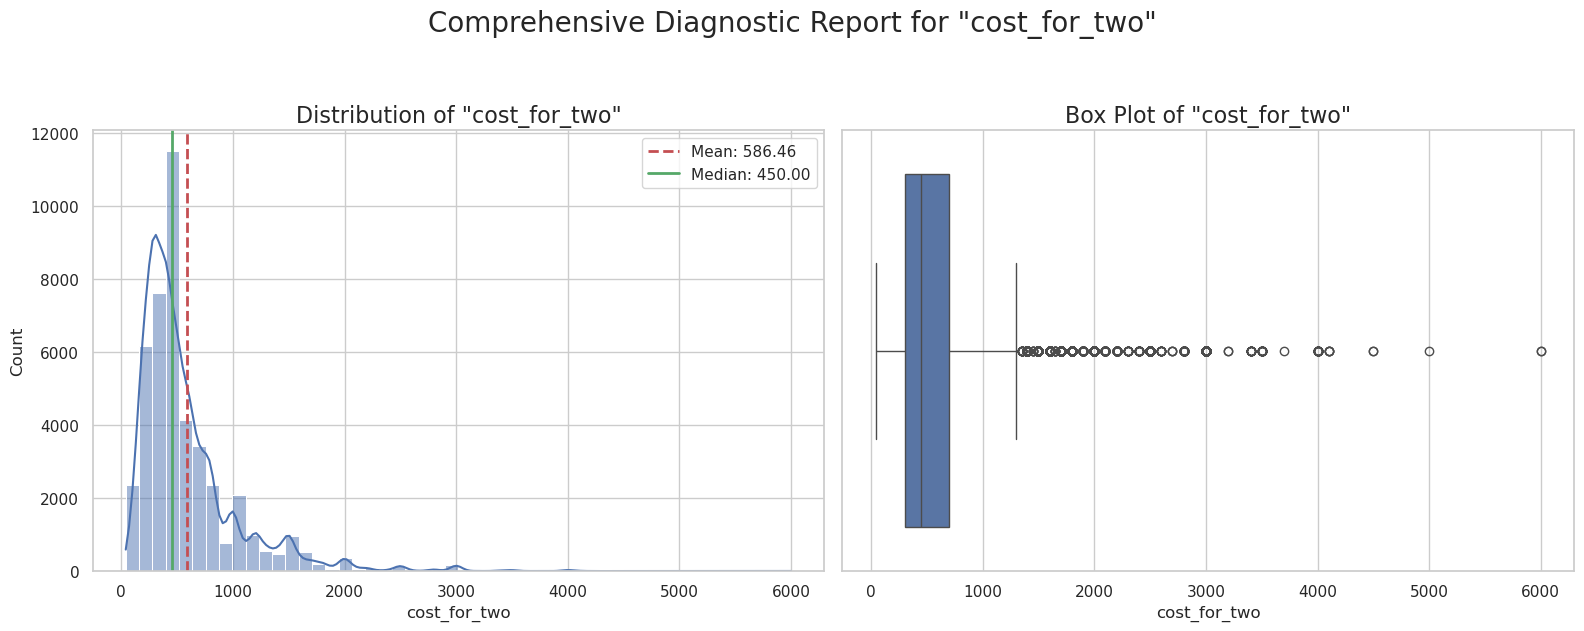

                    --------------------------------------------------
                    STATISTICAL ANALYSIS REPORT: 'cost_for_two'
                    --------------------------------------------------

Central Tendency:
  - Mean:                586.46
  - Median:              450.00

Dispersion:
  - Standard Deviation:  454.82
  - Interquartile Range: 400.00 (from Q1=300.00 to Q3=700.00)

Shape of Distribution:
  - Skewness:            2.48 (Symmetrical ≈ 0, Right-skewed > 0)
  - Kurtosis:            9.49 (Normal ≈ 0, Heavy-tailed > 0)

Outlier Analysis (using 1.5 * IQR Rule):
  - Calculated Lower Bound: -300.00
  - Calculated Upper Bound: 1,300.00
  - Potential Outliers Found: 3,236 (7.16% of the data)
                    --------------------------------------------------


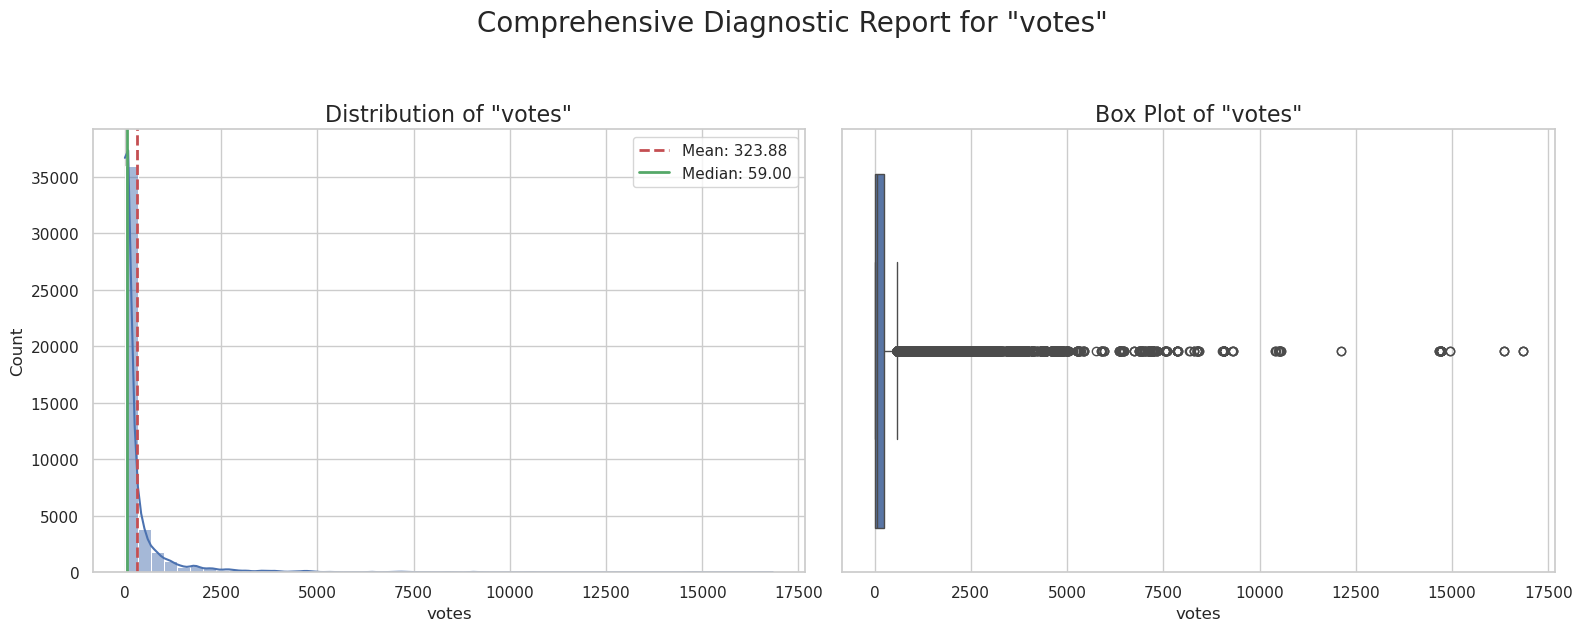

                    --------------------------------------------------
                    STATISTICAL ANALYSIS REPORT: 'votes'
                    --------------------------------------------------

Central Tendency:
  - Mean:                323.88
  - Median:              59.00

Dispersion:
  - Standard Deviation:  851.16
  - Interquartile Range: 226.00 (from Q1=15.00 to Q3=241.00)

Shape of Distribution:
  - Skewness:            7.13 (Symmetrical ≈ 0, Right-skewed > 0)
  - Kurtosis:            79.20 (Normal ≈ 0, Heavy-tailed > 0)

Outlier Analysis (using 1.5 * IQR Rule):
  - Calculated Lower Bound: -324.00
  - Calculated Upper Bound: 580.00
  - Potential Outliers Found: 5,975 (13.22% of the data)
                    --------------------------------------------------


In [49]:
# Analyze the 'cost_for_two' column.
# You will get the plots and the text report together.
analyze_numerical_feature(df, "cost_for_two")

# Analyze the 'votes' column.
# Again, plots and text report will appear together.
analyze_numerical_feature(df, "votes")

### 6.2. Applying Log Transformation

To address the severe skewness, we apply a **log transformation** (`np.log1p`) to `cost_for_two` and `votes`. This is a powerful technique to "squish" the long tail of the distribution and make it more symmetrical.

The "after" analysis shows a dramatic improvement:
-   Skewness for both variables is now close to zero.
-   The mean and median are nearly identical.
-   The number of "statistical outliers" is drastically reduced.

**Decision on Final Outliers:**
The few remaining outliers after transformation are considered **true outliers** (e.g., genuinely famous or expensive restaurants). Removing them would mean losing valuable information. Therefore, we will **keep these outliers** and allow our tree-based models (like XGBoost) to learn from them. The original and transformed columns are both kept for maximum flexibility in future notebooks.

In [50]:
import numpy as np

# Let's work on a copy of your imputed dataframe
df_transformed = df.copy()

print("--- Applying Log Transformation ---")

# --- Transforming 'cost_for_two' ---
# We create a new column to hold the transformed data
df_transformed["cost_log"] = np.log1p(df_transformed["cost_for_two"])
print("Created 'cost_log' column.")

# --- Transforming 'votes' ---
# Create another new column for the transformed votes
df_transformed["votes_log"] = np.log1p(df_transformed["votes"])
print("Created 'votes_log' column.")

print("\n--- Transformation Complete. Now, let's re-run the analysis. ---")

--- Applying Log Transformation ---
Created 'cost_log' column.
Created 'votes_log' column.

--- Transformation Complete. Now, let's re-run the analysis. ---


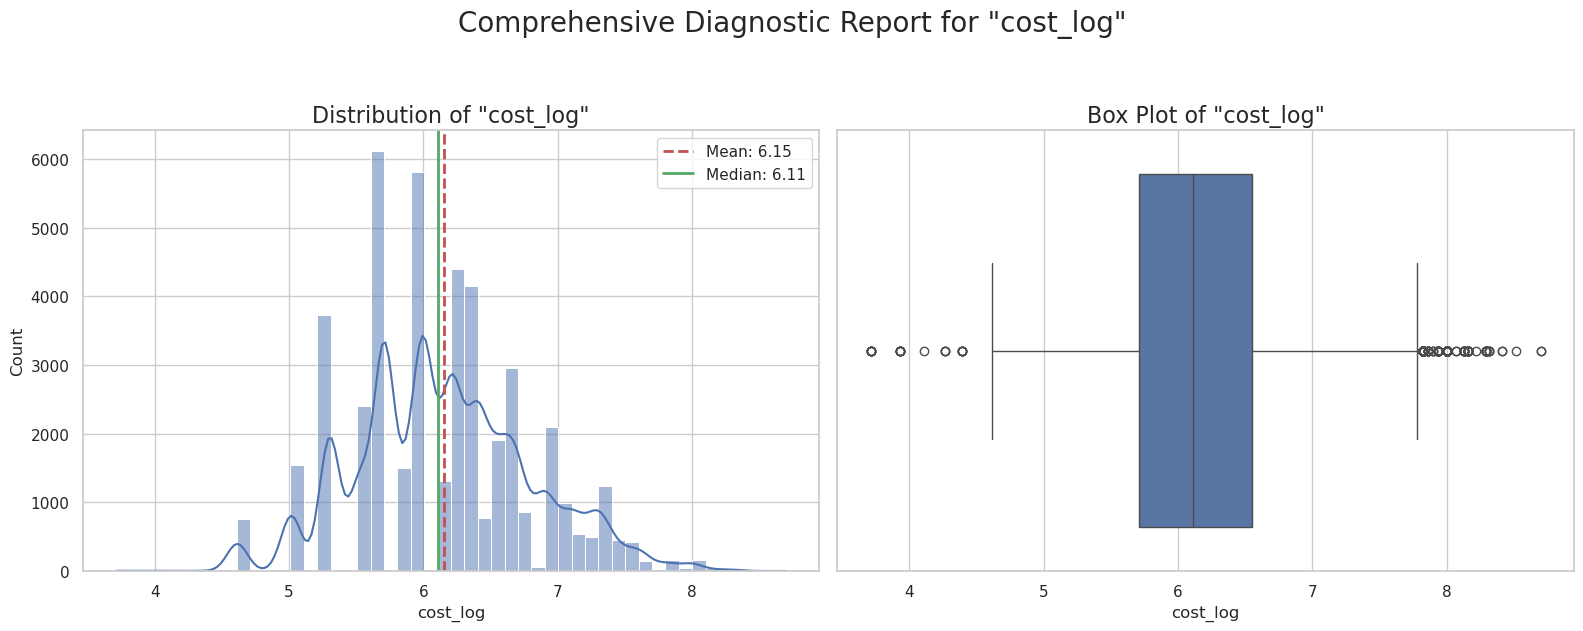

                    --------------------------------------------------
                    STATISTICAL ANALYSIS REPORT: 'cost_log'
                    --------------------------------------------------

Central Tendency:
  - Mean:                6.15
  - Median:              6.11

Dispersion:
  - Standard Deviation:  0.66
  - Interquartile Range: 0.85 (from Q1=5.71 to Q3=6.55)

Shape of Distribution:
  - Skewness:            0.23 (Symmetrical ≈ 0, Right-skewed > 0)
  - Kurtosis:            -0.01 (Normal ≈ 0, Heavy-tailed > 0)

Outlier Analysis (using 1.5 * IQR Rule):
  - Calculated Lower Bound: 4.44
  - Calculated Upper Bound: 7.82
  - Potential Outliers Found: 470 (1.04% of the data)
                    --------------------------------------------------


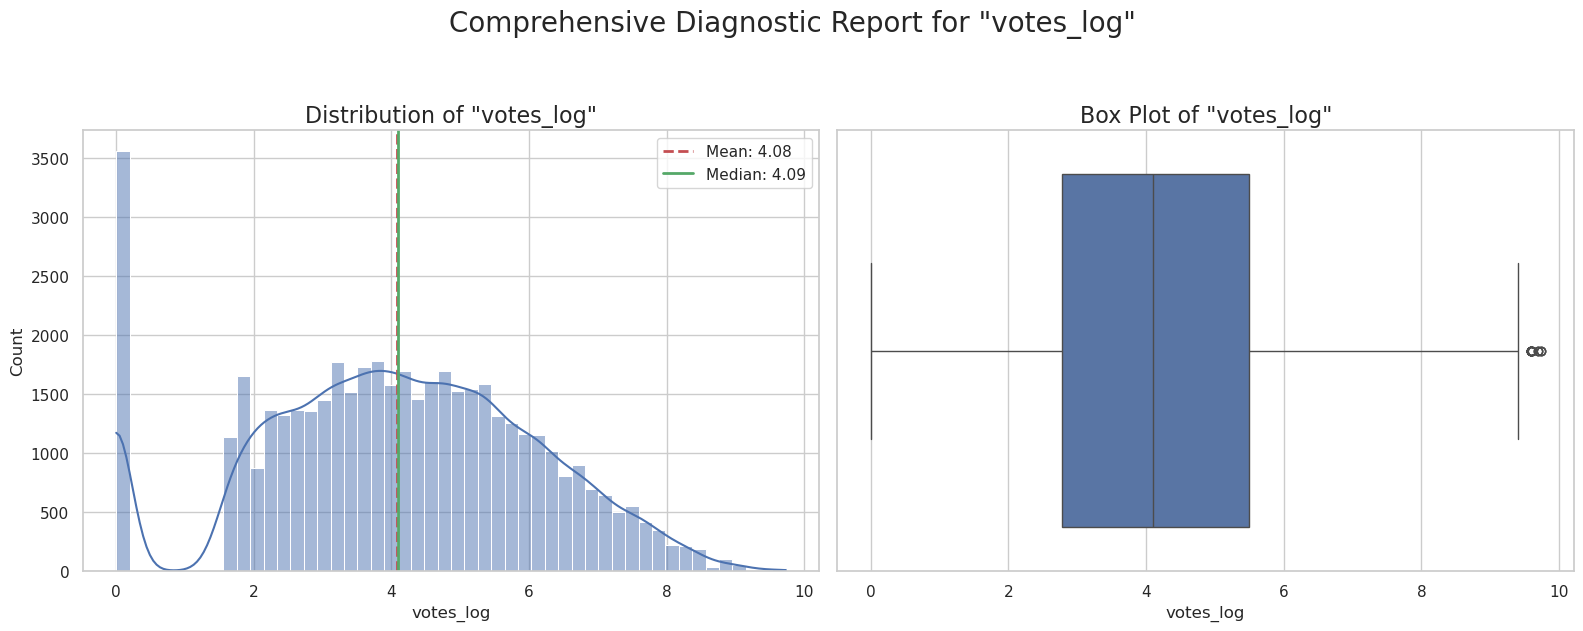

                    --------------------------------------------------
                    STATISTICAL ANALYSIS REPORT: 'votes_log'
                    --------------------------------------------------

Central Tendency:
  - Mean:                4.08
  - Median:              4.09

Dispersion:
  - Standard Deviation:  2.01
  - Interquartile Range: 2.72 (from Q1=2.77 to Q3=5.49)

Shape of Distribution:
  - Skewness:            -0.14 (Symmetrical ≈ 0, Right-skewed > 0)
  - Kurtosis:            -0.34 (Normal ≈ 0, Heavy-tailed > 0)

Outlier Analysis (using 1.5 * IQR Rule):
  - Calculated Lower Bound: -1.30
  - Calculated Upper Bound: 9.56
  - Potential Outliers Found: 23 (0.05% of the data)
                    --------------------------------------------------


In [51]:
# --- Analyze the TRANSFORMED 'cost_for_two' ---
analyze_numerical_feature(df_transformed, "cost_log")

# --- Analyze the TRANSFORMED 'votes' ---
analyze_numerical_feature(df_transformed, "votes_log")

In [52]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             45187 non-null  object 
 1   address         45187 non-null  object 
 2   name            45187 non-null  object 
 3   online_order    45187 non-null  int64  
 4   book_table      45187 non-null  int64  
 5   rate            45187 non-null  float64
 6   votes           45187 non-null  int64  
 7   location        45187 non-null  object 
 8   rest_type       45187 non-null  object 
 9   dish_liked      45187 non-null  object 
 10  cuisines        45187 non-null  object 
 11  cost_for_two    45187 non-null  float64
 12  reviews_list    45187 non-null  object 
 13  menu_item       45187 non-null  object 
 14  listed_in_type  45187 non-null  object 
 15  listed_in_city  45187 non-null  object 
 16  cost_log        45187 non-null  float64
 17  votes_log       45187 non-null 

In [53]:
# EXAMPLE CONFIGURATION:
# "I've decided to cap 'cost_for_two' at both ends, but I will only cap the
# extreme high end of 'votes' because the low end is fine."

outlier_config = {
    "cost_for_two": {"method": "quantile", "low": 0.01, "high": 0.99},
    "votes": {"method": "quantile", "high": 0.99},
}

# If you decide NOT to touch 'votes', your config would be even simpler:
# outlier_config = {
#     'cost_for_two': {'method': 'quantile', 'low': 0.01, 'high': 0.99}
# }

## I am not going to perform outlier Treatment i believe the few outliers after the log transformation are True Outliers and they are necessary for the model.

In [54]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandarallel import pandarallel

# Assume logger is already configured
# logger = logging.getLogger()

# --- Initialize Pandarallel ---
# This line should be run once in your notebook to enable parallel processing
pandarallel.initialize(progress_bar=True, nb_workers=4)  # Use half your CPU cores


def handle_outliers_like_a_pro(df: pd.DataFrame, config: dict) -> pd.DataFrame:
    """
    A comprehensive function to analyze, visualize, and treat outliers based on a configuration.

    Args:
        df (pd.DataFrame): The input DataFrame.
        config (dict): A configuration dictionary specifying which columns to treat and how.
                       Example:
                       config = {
                           'cost_for_two': {'method': 'quantile', 'low': 0.01, 'high': 0.99},
                           'votes': {'method': 'quantile', 'high': 0.99}
                       }

    Returns:
        pd.DataFrame: A new DataFrame with outliers treated.
    """
    logger.info("--- Starting God-Level Outlier Handling ---")

    df_processed = df.copy()
    columns_to_process = list(config.keys())

    # --- STAGE 1: VISUALIZE "BEFORE" STATE ---
    logger.info(
        f"Stage 1: Visualizing the 'before' state for columns: {columns_to_process}"
    )

    plt.figure(figsize=(8 * len(columns_to_process), 5))
    for i, col in enumerate(columns_to_process, 1):
        plt.subplot(1, len(columns_to_process), i)
        sns.boxplot(x=df_processed[col])
        plt.title(f'"{col}" - Before Treatment')
    plt.suptitle("Outlier Analysis: Before Treatment", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- STAGE 2: APPLY OUTLIER TREATMENT ---
    logger.info("Stage 2: Applying outlier treatment based on configuration...")

    for col, params in config.items():
        if params["method"] == "quantile":
            logger.info(f"Processing '{col}' with quantile capping...")

            # --- Lower bound capping ---
            if "low" in params:
                q_low = df_processed[col].quantile(params["low"])

                # Using pandarallel for the apply step
                df_processed[col] = df_processed[col].parallel_apply(
                    lambda x: q_low if x < q_low else x
                )
                logger.info(
                    f"Capped lower bound for '{col}' at {params['low']*100:.0f}th percentile ({q_low:.2f})."
                )

            # --- Upper bound capping ---
            if "high" in params:
                q_high = df_processed[col].quantile(params["high"])

                # Using pandarallel for the apply step
                df_processed[col] = df_processed[col].parallel_apply(
                    lambda x: q_high if x > q_high else x
                )
                logger.info(
                    f"Capped upper bound for '{col}' at {params['high']*100:.0f}th percentile ({q_high:.2f})."
                )

        # You could add other methods here later, like 'log_transform'
        # elif params['method'] == 'log_transform':
        #     df_processed[col] = np.log1p(df_processed[col])
        #     logger.info(f"Applied log transformation to '{col}'.")

    logger.success("Stage 2 complete. All treatments applied.")

    # --- STAGE 3: VISUALIZE "AFTER" STATE ---
    logger.info(
        f"Stage 3: Visualizing the 'after' state for columns: {columns_to_process}"
    )

    plt.figure(figsize=(8 * len(columns_to_process), 5))
    for i, col in enumerate(columns_to_process, 1):
        plt.subplot(1, len(columns_to_process), i)
        sns.boxplot(x=df_processed[col])
        plt.title(f'"{col}" - After Treatment')
    plt.suptitle("Outlier Analysis: After Treatment", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    logger.success("Outlier handling complete.")

    return df_processed

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 7. Final DataFrame & Export Strategy

This notebook has successfully transformed the raw Zomato data into a clean, complete, and enriched dataset. We now have our "golden" source DataFrame, ready for the next stages of the project.

### 7.1. Final Data Structure

The final processed DataFrame (`df_processed`) has the following properties:
-   **Shape:** [Final Shape, e.g., (45187, 18)]
-   **No Missing Values:** All NaNs have been strategically imputed.
-   **No Duplicates:** All duplicate restaurants have been removed or merged.
-   **Correct Data Types:** All columns are in the correct format (numeric, object, or list).
-   **Enriched Features:** Contains both original (`cost_for_two`, `votes`) and log-transformed (`cost_log`, `votes_log`) columns.

### 7.2. Preparing for Export

As planned, we will slice this golden DataFrame into specialized datasets for different downstream tasks. This modular approach is a best practice for managing complex data science projects.

- **`df_eda_tabular`**: For general EDA and training tabular models. Excludes heavy text columns.
- **`df_nlp`**: For natural language processing tasks. Contains unique identifiers and the review lists.
- **`df_geo`**: For geolocation analysis and mapping. Contains location and address information.

The code below will generate and save these datasets in the high-performance **Parquet** format, which preserves data types (including our precious lists) and is highly efficient.

In [67]:
import ast
import logging
import os

import pandas as pd

# Assume logger is already configured
# logger = logging.getLogger()


def _standardize_text_to_list(series: pd.Series) -> pd.Series:
    """
    The ultimate helper function to convert a Series containing various text
    formats (comma-separated, stringified lists, etc.) into a Series of
    clean Python lists.

    Args:
        series (pd.Series): The input Series/column to standardize.

    Returns:
        pd.Series: A new Series where each element is a sorted list of strings.
    """

    def parse_single_cell(cell_value):
        # Case 1: Already a list. Just clean it.
        if isinstance(cell_value, list):
            return sorted([str(s).strip() for s in cell_value if str(s).strip()])

        # Case 2: Not a string (e.g., NaN). Return empty list.
        if not isinstance(cell_value, str):
            return []

        # Case 3: It's a string. Try to parse it as a list literal first.
        # This handles formats like "['A', 'B']" from reviews_list/menu_item.
        if cell_value.startswith("[") and cell_value.endswith("]"):
            try:
                parsed_list = ast.literal_eval(cell_value)
                if isinstance(parsed_list, list):
                    return sorted(
                        [str(s).strip() for s in parsed_list if str(s).strip()]
                    )
            except (ValueError, SyntaxError):
                # If it fails, it might be a string with brackets inside, so we fall through
                pass

        # Case 4: It's a comma-separated string (or a string that failed ast parsing).
        # This handles cuisines, rest_type, dish_liked, etc.
        # Also handles the "fixed" menu_item format.
        return sorted([s.strip() for s in cell_value.split(",") if s.strip()])

    # Apply the robust parsing logic to every cell in the Series
    return series.apply(parse_single_cell)


def export_specialized_datasets(
    df_processed: pd.DataFrame, output_dir: str = "../data/processed"
):
    """
    Takes the final, fully cleaned DataFrame, standardizes all multi-value text
    columns to lists, and exports multiple specialized Parquet files.
    """
    logger.info("--- Starting Final Export of Specialized Datasets ---")

    os.makedirs(output_dir, exist_ok=True)
    logger.info(f"Output directory set to: '{output_dir}'")

    df_master = df_processed.copy()

    # --- Step 1: Final Data Type Standardization using the ULTIMATE helper ---
    # Define all columns that should end up as lists of strings.
    cols_to_standardize = ["rest_type", "cuisines", "dish_liked", "menu_item"]

    for col in cols_to_standardize:
        logger.info(f"Standardizing column '{col}' to a clean list format...")
        df_master[col] = _standardize_text_to_list(df_master[col])

    logger.success("All multi-value text columns have been standardized to list type.")

    # --- Step 2: Export the Golden Master File ---
    master_path = os.path.join(output_dir, "zomato_master_processed.parquet")
    logger.info(
        f"Exporting the golden master file ({df_master.shape}) to '{master_path}'..."
    )
    df_master.to_parquet(master_path, index=False)
    logger.success("Master file exported successfully.")

    # --- Step 3: Create and Export Specialized Datasets (slicing from df_master) ---

    # 3.1: EDA & Tabular Modeling Dataset
    logger.info("Creating the EDA & Tabular Modeling dataset...")
    cols_eda_tabular = [
        "name",
        "address",
        "online_order",
        "book_table",
        "rate",
        "votes",
        "location",
        "rest_type",
        "dish_liked",
        "cuisines",
        "listed_in_type",
        "listed_in_city",
        "cost_for_two",
        "cost_log",
        "votes_log",
    ]
    df_eda_tabular = df_master[cols_eda_tabular]
    eda_path = os.path.join(output_dir, "zomato_eda_tabular.parquet")
    logger.info(f"Exporting EDA dataset ({df_eda_tabular.shape}) to '{eda_path}'...")
    df_eda_tabular.to_parquet(eda_path, index=False)
    logger.success("EDA dataset exported.")

    # 3.2: NLP Dataset
    logger.info("Creating the NLP dataset...")
    cols_nlp = [
        "name",
        "address",
        "rate",
        "reviews_list",
        "menu_item",
        "cuisines",
        "dish_liked",
    ]
    df_nlp = df_master[cols_nlp]
    nlp_path = os.path.join(output_dir, "zomato_nlp.parquet")
    logger.info(f"Exporting NLP dataset ({df_nlp.shape}) to '{nlp_path}'...")
    df_nlp.to_parquet(nlp_path, index=False)
    logger.success("NLP dataset exported.")

    # 3.3: Geolocation Dataset
    logger.info("Creating the Geolocation dataset...")
    cols_geo = ["name", "address", "rate", "location", "listed_in_city"]
    df_geo = df_master[cols_geo]
    geo_path = os.path.join(output_dir, "zomato_geo.parquet")
    logger.info(f"Exporting Geolocation dataset ({df_geo.shape}) to '{geo_path}'...")
    df_geo.to_parquet(geo_path, index=False)
    logger.success("Geolocation dataset exported.")

    logger.info("--- All datasets have been successfully exported. ---")

In [68]:
export_specialized_datasets(df_transformed)

2025-08-26 18:44:42 | INFO     | __main__:export_specialized_datasets:59 - --- Starting Final Export of Specialized Datasets ---
2025-08-26 18:44:42 | INFO     | __main__:export_specialized_datasets:62 - Output directory set to: '../data/processed'
2025-08-26 18:44:42 | INFO     | __main__:export_specialized_datasets:71 - Standardizing column 'rest_type' to a clean list format...
2025-08-26 18:44:42 | INFO     | __main__:export_specialized_datasets:71 - Standardizing column 'cuisines' to a clean list format...
2025-08-26 18:44:42 | INFO     | __main__:export_specialized_datasets:71 - Standardizing column 'dish_liked' to a clean list format...
2025-08-26 18:44:43 | INFO     | __main__:export_specialized_datasets:71 - Standardizing column 'menu_item' to a clean list format...
2025-08-26 18:44:43 | SUCCESS  | __main__:export_specialized_datasets:74 - All multi-value text columns have been standardized to list type.
2025-08-26 18:44:43 | INFO     | __main__:export_specialized_datasets:78 -

In [57]:
def explode_and_deduplicate_reviews(df: pd.DataFrame) -> pd.DataFrame:
    """
    Explodes the 'reviews_list' column to create a new DataFrame where each
    row represents a single review, and then removes duplicate reviews.
    """
    logger.info("--- Exploding and deduplicating reviews ---")

    # 1. Select the necessary columns using the correct syntax.
    #    Using .loc to be explicit and avoid SettingWithCopyWarning.
    df_exploded = df.loc[
        :,
        [
            "url",
            "name",
            "rate",
            "votes",
            "cost_for_two",
            "listed_in_city",
            "rest_type",
            "cuisines",
            "menu_item",
            "dish_liked",
            "reviews_list",
        ],
    ].copy()

    # 2. Drop rows where 'reviews_list' is empty or null.
    #    This makes the explode operation safer and cleaner.
    df_exploded = df_exploded.dropna(subset=["reviews_list"])
    df_exploded = df_exploded[
        df_exploded["reviews_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]

    # 3. Use the .explode() method correctly.
    df_exploded = df_exploded.explode("reviews_list")

    # 4. Split the tuple into two new columns.
    #    This part of your code was perfect.
    df_exploded["review_rating"] = df_exploded["reviews_list"].str[0]
    df_exploded["review_text"] = df_exploded["reviews_list"].str[1]

    # Drop the original list column as it's no longer needed
    df_exploded = df_exploded.drop(columns=["reviews_list"])

    # 5. Check for and remove duplicate reviews.
    #    Your logic here was also perfect.
    duplicate_reviews = df_exploded.duplicated(subset=["review_text"]).sum()

    if duplicate_reviews > 0:
        logger.info(f"Found {duplicate_reviews:,} duplicate reviews to remove.")
        df_exploded = df_exploded.drop_duplicates(subset=["review_text"], keep="first")
        logger.success(f"Successfully removed {duplicate_reviews:,} duplicates.")
    else:
        logger.warning("No duplicate reviews were found.")

    df_exploded = df_exploded.reset_index(drop=True)
    logger.info("Resetting index for the new reviews DataFrame.")

    logger.success(
        f"Operation completed. Final shape of unique reviews DataFrame: {df_exploded.shape}"
    )

    return df_exploded

In [58]:
# df_nlp = explode_and_deduplicate_reviews(df)